In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import math
from scipy.integrate import odeint

#from BO model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, Input, Activation, Dropout
from keras import backend as K
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow as tf
from keras.models import Model
from keras.models import load_model

import pickle

# Check the prediction performance of FP model using condition 4

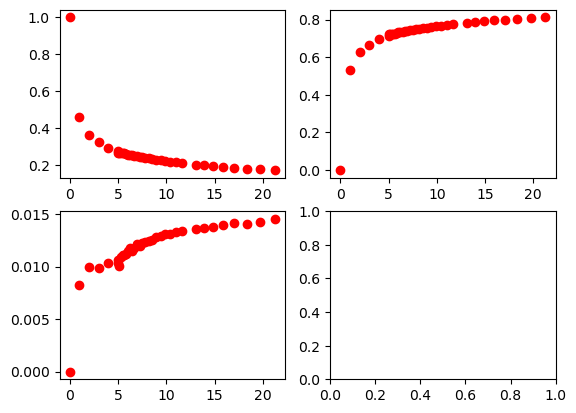

In [2]:
# extracting y_actual data
raw_input = pd.read_excel('Updated_photochemical_Experiment.xlsx','Sheet4')

X = raw_input.values.astype(np.float64)
X1 = X[:,2] # data collection timestamp (residence time)
Y1 = X[:,10] # concentration of A
Y2 = X[:,11] # concentration of C
Y3 = X[:,9] # concentration of E
fig, ax = plt.subplots(2, 2)
ax[0,0].scatter(X1,Y1, color='r')
ax[0,1].scatter(X1,Y2, color='r')
ax[1,0].scatter(X1,Y3, color='r')
plt.show()

In [3]:
# reformat data collection timestamp
X1 = [round(X1[i], 2) for i in range(len(X1))]
print(len(X1))
print(X1)

36
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 5.04, 5.15, 5.3, 5.46, 5.64, 5.82, 6.02, 6.23, 6.45, 6.69, 6.95, 7.22, 7.52, 7.84, 8.19, 8.56, 8.97, 9.41, 9.89, 10.42, 11.0, 11.63, 13.1, 13.95, 14.89, 15.92, 17.07, 18.33, 19.72, 21.24]


In [4]:
# define parameters
R = (6.4*10e-3)/2 # m
phi = 1.11 #0.21
Vr = 4.78 * 10e-6 # m3
KA = 11000*10e2*10e-3 # M-1∙m-1
alpha = 11000*10e2*10e-3 # M-1∙m-1

# three different qp w.r.t three different power (as the initial condition)
qp_480 = 1.3 * 10e-4 # moles photons · m-2 · s-1
qp_240 = qp_480*240/480
qp_120 = qp_480*120/480

print(qp_120)
print(qp_240)
print(qp_480)

num_step = 36
num_shot = 7

0.00032500000000000004
0.0006500000000000001
0.0013000000000000002


In [5]:
# first-principles parameters optimized using 7 training samples
phi_n = 3.55917216e-01
mpc = 2.47444235e-01
ka = 9.60981609e-01
kc = 8.08286276e+01
k1 = 2.00697102e+00
k2 =  1.06903830e-02

In [6]:
def CSimulation(CAo,qp):

    CA = 1
    CC = 0
    CE = 0

    CA_list = list()
    CC_list = list()
    CE_list = list()

    t_step = 0.01

    for i in range(2200):
        dCAndtau = -((phi_n/CAo)*(qp/Vr)*(ka*CA*CAo/(mpc+ka*CA*CAo+kc*CC*CAo))*(1-np.exp(-(mpc+ka*CA*CAo+kc*CC*CAo)*2*R))) #- (k1*C[0] + k2*C[0]) #-k1*C[0]**3-k2*C[0]**2 #*C[0]*CAo
        dCCndtau = (k1/(k1+k2)**2)*((1/CAo)*(qp/Vr)*(ka*CA*CAo/(mpc+ka*CA*CAo+kc*CC*CAo))*(1-np.exp(-(mpc+ka*CA*CAo+kc*CC*CAo)*2*R)))**2   #C[0] #**3 #**3
        dCEndtau = (k2/(k1+k2)**1)*((1/CAo)*(qp/Vr)*(ka*CA*CAo/(mpc+ka*CA*CAo+kc*CC*CAo))*(1-np.exp(-(mpc+ka*CA*CAo+kc*CC*CAo)*2*R)))**1   #C[0] #**2 #**2


        CA += dCAndtau * t_step
        CC += dCCndtau * t_step
        CE += dCEndtau * t_step
        if round(i*t_step, 2) in X1:
            CA_list.append(CA)
            CC_list.append(CC)
            CE_list.append(CE)


    return [CA_list,CC_list,CE_list]

In [7]:
CA_list,CC_list,CE_list = CSimulation(0.3,qp_480)

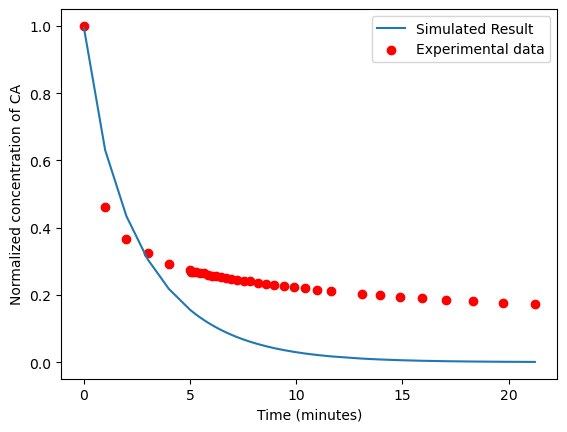

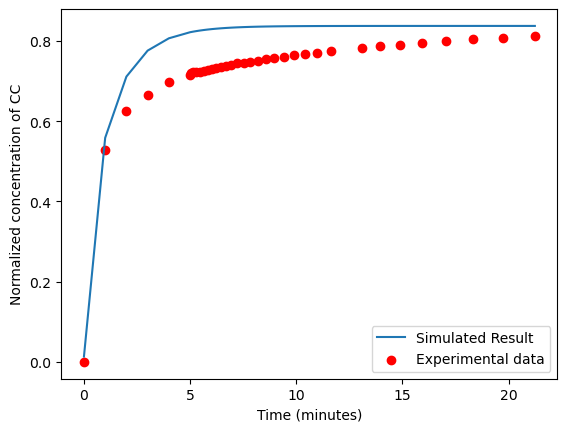

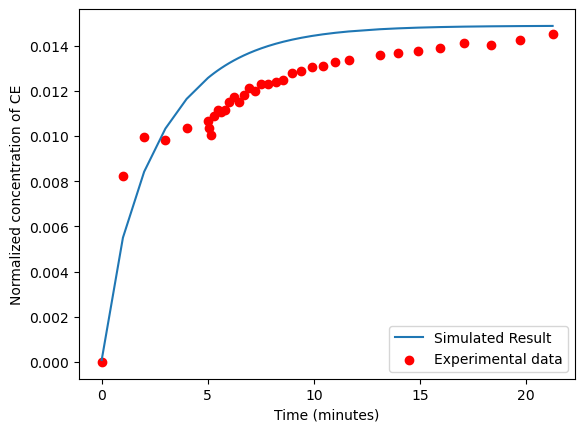

In [8]:
plt.plot(X1,CA_list)
plt.scatter(X1,Y1, color='r')
plt.legend(['Simulated Result','Experimental data'])
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized concentration of CA")
plt.show()
plt.plot(X1,CC_list)
plt.scatter(X1,Y2, color='r')
plt.legend(['Simulated Result','Experimental data'])
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized concentration of CC")
plt.show()
plt.plot(X1,CE_list)
plt.scatter(X1,Y3, color='r')
plt.legend(['Simulated Result','Experimental data'])
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized concentration of CE")
plt.show()

# Collect data from FP model

In [9]:
# test 1 full stability region
CAo_list = np.linspace(1, 50, 50, endpoint=True)/10
qp_list = np.linspace(325, 325*5, 50, endpoint=True)/1e6
print(CAo_list)
print(qp_list)

CA_output = list()
CC_output = list()
CE_output = list()

CAo_input = list()
qp_input = list()
CA_input = list()
CC_input = list()
CE_input = list()

# simulate data
for CAo in CAo_list:
    for qp in qp_list:
        CAo_input.append(CAo)
        qp_input.append(qp)
        CA_input.append(1.0)
        CC_input.append(0.0)
        CE_input.append(0.0)

        CA_list,CC_list,CE_list = CSimulation(CAo,qp)
        CA_output.append(CA_list)
        CC_output.append(CC_list)
        CE_output.append(CE_list)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6
 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5. ]
[0.000325   0.00035153 0.00037806 0.00040459 0.00043112 0.00045765
 0.00048418 0.00051071 0.00053724 0.00056378 0.00059031 0.00061684
 0.00064337 0.0006699  0.00069643 0.00072296 0.00074949 0.00077602
 0.00080255 0.00082908 0.00085561 0.00088214 0.00090867 0.0009352
 0.00096173 0.00098827 0.0010148  0.00104133 0.00106786 0.00109439
 0.00112092 0.00114745 0.00117398 0.00120051 0.00122704 0.00125357
 0.0012801  0.00130663 0.00133316 0.00135969 0.00138622 0.00141276
 0.00143929 0.00146582 0.00149235 0.00151888 0.00154541 0.00157194
 0.00159847 0.001625  ]


In [10]:
# collate input for RNN
CAo_input = np.array(CAo_input).reshape(-1,1,1)
qp_input = np.array(qp_input).reshape(-1,1,1)

CA_input = np.array(CA_input).reshape(-1,1,1)
CC_input = np.array(CC_input).reshape(-1,1,1)
CE_input = np.array(CE_input).reshape(-1,1,1)

RNN_input = np.concatenate((CA_input, CC_input, qp_input, CAo_input), axis=2)
print(RNN_input[0,:,:])
RNN_input = RNN_input.repeat(36, axis=1)
print("RNN_input shape is {}".format(RNN_input.shape))

[[1.00e+00 0.00e+00 3.25e-04 1.00e-01]]
RNN_input shape is (2500, 36, 4)


In [11]:
CA_output = np.array(CA_output).reshape(-1, 36, 1)
CC_output = np.array(CC_output).reshape(-1, 36, 1)
CE_output = np.array(CE_output).reshape(-1, 36, 1)
RNN_output = np.concatenate((CA_output, CC_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))

RNN_output shape is (2500, 36, 2)


In [12]:
print(RNN_output[0,:,0])

[0.99852791 0.86296622 0.74746869 0.64845803 0.56321045 0.48958231
 0.48685325 0.47942892 0.46949234 0.45912662 0.44774584 0.43665438
 0.42466026 0.41242891 0.40000089 0.38687832 0.37315659 0.35943087
 0.34478076 0.32982109 0.31421093 0.2985209  0.28205777 0.26540811
 0.24837289 0.23083945 0.21307565 0.19533363 0.15948952 0.14185603
 0.1246211  0.10813433 0.09229296 0.0775897  0.06407266 0.05197244]


In [13]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(RNN_input, RNN_output, test_size=0.2, random_state=123)

# define scalers for both X and y base on training data only
scaler_X = preprocessing.StandardScaler().fit(X_train.reshape(-1, 4))
scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1, 2))

X_train = scaler_X.transform(X_train.reshape(-1, 4)).reshape(-1, 36, 4)
X_test = scaler_X.transform(X_test.reshape(-1, 4)).reshape(-1, 36, 4)
y_train = scaler_y.transform(y_train.reshape(-1, 2)).reshape(-1, 36, 2)
y_test = scaler_y.transform(y_test.reshape(-1, 2)).reshape(-1, 36, 2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2000, 36, 4)
(500, 36, 4)
(2000, 36, 2)
(500, 36, 2)


In [14]:
model1 = Sequential()
model1.add(SimpleRNN(64, activation='relu', return_sequences=True))
model1.add(SimpleRNN(64, activation='relu', return_sequences=True))
model1.add(Dense(2, activation='linear'))
model1.compile(optimizer='adam', loss='mse', metrics=['mse'])

history = model1.fit(X_train, y_train, epochs=1000, batch_size=256, validation_split=0.25, verbose=2)

Epoch 1/1000
6/6 - 2s - loss: 0.8598 - mse: 0.8598 - val_loss: 0.6751 - val_mse: 0.6751 - 2s/epoch - 313ms/step
Epoch 2/1000
6/6 - 0s - loss: 0.5677 - mse: 0.5677 - val_loss: 0.4756 - val_mse: 0.4756 - 295ms/epoch - 49ms/step
Epoch 3/1000
6/6 - 0s - loss: 0.4449 - mse: 0.4449 - val_loss: 0.4215 - val_mse: 0.4215 - 209ms/epoch - 35ms/step
Epoch 4/1000
6/6 - 0s - loss: 0.3939 - mse: 0.3939 - val_loss: 0.3684 - val_mse: 0.3684 - 307ms/epoch - 51ms/step
Epoch 5/1000
6/6 - 0s - loss: 0.3446 - mse: 0.3446 - val_loss: 0.3188 - val_mse: 0.3188 - 304ms/epoch - 51ms/step
Epoch 6/1000
6/6 - 0s - loss: 0.2948 - mse: 0.2948 - val_loss: 0.2657 - val_mse: 0.2657 - 283ms/epoch - 47ms/step
Epoch 7/1000
6/6 - 0s - loss: 0.2449 - mse: 0.2449 - val_loss: 0.2216 - val_mse: 0.2216 - 220ms/epoch - 37ms/step
Epoch 8/1000
6/6 - 0s - loss: 0.1938 - mse: 0.1938 - val_loss: 0.1718 - val_mse: 0.1718 - 281ms/epoch - 47ms/step
Epoch 9/1000
6/6 - 0s - loss: 0.1609 - mse: 0.1609 - val_loss: 0.1534 - val_mse: 0.1534 - 

Epoch 73/1000
6/6 - 0s - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0040 - val_mse: 0.0040 - 310ms/epoch - 52ms/step
Epoch 74/1000
6/6 - 0s - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0065 - val_mse: 0.0065 - 192ms/epoch - 32ms/step
Epoch 75/1000
6/6 - 0s - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0048 - val_mse: 0.0048 - 261ms/epoch - 43ms/step
Epoch 76/1000
6/6 - 0s - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0036 - val_mse: 0.0036 - 335ms/epoch - 56ms/step
Epoch 77/1000
6/6 - 0s - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0036 - val_mse: 0.0036 - 281ms/epoch - 47ms/step
Epoch 78/1000
6/6 - 0s - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0031 - val_mse: 0.0031 - 222ms/epoch - 37ms/step
Epoch 79/1000
6/6 - 0s - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0031 - val_mse: 0.0031 - 344ms/epoch - 57ms/step
Epoch 80/1000
6/6 - 0s - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0038 - val_mse: 0.0038 - 268ms/epoch - 45ms/step
Epoch 81/1000
6/6 - 0s - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0033 - val_mse

Epoch 144/1000
6/6 - 0s - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0016 - val_mse: 0.0016 - 240ms/epoch - 40ms/step
Epoch 145/1000
6/6 - 0s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0015 - val_mse: 0.0015 - 277ms/epoch - 46ms/step
Epoch 146/1000
6/6 - 0s - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011 - 303ms/epoch - 50ms/step
Epoch 147/1000
6/6 - 0s - loss: 9.7970e-04 - mse: 9.7970e-04 - val_loss: 0.0012 - val_mse: 0.0012 - 216ms/epoch - 36ms/step
Epoch 148/1000
6/6 - 0s - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0033 - val_mse: 0.0033 - 254ms/epoch - 42ms/step
Epoch 149/1000
6/6 - 0s - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0022 - val_mse: 0.0022 - 325ms/epoch - 54ms/step
Epoch 150/1000
6/6 - 0s - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0022 - val_mse: 0.0022 - 305ms/epoch - 51ms/step
Epoch 151/1000
6/6 - 0s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0056 - val_mse: 0.0056 - 181ms/epoch - 30ms/step
Epoch 152/1000
6/6 - 0s - loss: 0.0029 - mse: 0.0029 - val_loss:

6/6 - 0s - loss: 6.2911e-04 - mse: 6.2911e-04 - val_loss: 6.5552e-04 - val_mse: 6.5552e-04 - 277ms/epoch - 46ms/step
Epoch 213/1000
6/6 - 0s - loss: 6.4183e-04 - mse: 6.4183e-04 - val_loss: 8.1041e-04 - val_mse: 8.1041e-04 - 179ms/epoch - 30ms/step
Epoch 214/1000
6/6 - 0s - loss: 7.8688e-04 - mse: 7.8688e-04 - val_loss: 7.2619e-04 - val_mse: 7.2619e-04 - 240ms/epoch - 40ms/step
Epoch 215/1000
6/6 - 0s - loss: 6.6971e-04 - mse: 6.6972e-04 - val_loss: 6.4616e-04 - val_mse: 6.4616e-04 - 323ms/epoch - 54ms/step
Epoch 216/1000
6/6 - 0s - loss: 7.3251e-04 - mse: 7.3251e-04 - val_loss: 0.0012 - val_mse: 0.0012 - 290ms/epoch - 48ms/step
Epoch 217/1000
6/6 - 0s - loss: 0.0010 - mse: 0.0010 - val_loss: 7.8167e-04 - val_mse: 7.8167e-04 - 213ms/epoch - 35ms/step
Epoch 218/1000
6/6 - 0s - loss: 7.0825e-04 - mse: 7.0825e-04 - val_loss: 0.0011 - val_mse: 0.0011 - 319ms/epoch - 53ms/step
Epoch 219/1000
6/6 - 0s - loss: 8.0620e-04 - mse: 8.0620e-04 - val_loss: 6.3252e-04 - val_mse: 6.3252e-04 - 277ms/e

Epoch 276/1000
6/6 - 0s - loss: 6.8207e-04 - mse: 6.8207e-04 - val_loss: 9.8722e-04 - val_mse: 9.8722e-04 - 306ms/epoch - 51ms/step
Epoch 277/1000
6/6 - 0s - loss: 7.6294e-04 - mse: 7.6294e-04 - val_loss: 7.2918e-04 - val_mse: 7.2918e-04 - 301ms/epoch - 50ms/step
Epoch 278/1000
6/6 - 0s - loss: 8.2317e-04 - mse: 8.2317e-04 - val_loss: 5.6203e-04 - val_mse: 5.6203e-04 - 233ms/epoch - 39ms/step
Epoch 279/1000
6/6 - 0s - loss: 7.5798e-04 - mse: 7.5798e-04 - val_loss: 9.8825e-04 - val_mse: 9.8825e-04 - 177ms/epoch - 30ms/step
Epoch 280/1000
6/6 - 0s - loss: 6.5430e-04 - mse: 6.5430e-04 - val_loss: 9.8419e-04 - val_mse: 9.8419e-04 - 276ms/epoch - 46ms/step
Epoch 281/1000
6/6 - 0s - loss: 6.6342e-04 - mse: 6.6342e-04 - val_loss: 7.3694e-04 - val_mse: 7.3694e-04 - 332ms/epoch - 55ms/step
Epoch 282/1000
6/6 - 0s - loss: 6.3646e-04 - mse: 6.3646e-04 - val_loss: 4.7481e-04 - val_mse: 4.7481e-04 - 223ms/epoch - 37ms/step
Epoch 283/1000
6/6 - 0s - loss: 4.8489e-04 - mse: 4.8489e-04 - val_loss: 4.8

Epoch 341/1000
6/6 - 0s - loss: 7.4043e-04 - mse: 7.4043e-04 - val_loss: 0.0011 - val_mse: 0.0011 - 265ms/epoch - 44ms/step
Epoch 342/1000
6/6 - 0s - loss: 6.4144e-04 - mse: 6.4144e-04 - val_loss: 6.1096e-04 - val_mse: 6.1096e-04 - 268ms/epoch - 45ms/step
Epoch 343/1000
6/6 - 0s - loss: 4.5528e-04 - mse: 4.5528e-04 - val_loss: 4.4959e-04 - val_mse: 4.4959e-04 - 172ms/epoch - 29ms/step
Epoch 344/1000
6/6 - 0s - loss: 4.1954e-04 - mse: 4.1954e-04 - val_loss: 6.1002e-04 - val_mse: 6.1002e-04 - 307ms/epoch - 51ms/step
Epoch 345/1000
6/6 - 0s - loss: 4.4577e-04 - mse: 4.4577e-04 - val_loss: 5.9743e-04 - val_mse: 5.9743e-04 - 302ms/epoch - 50ms/step
Epoch 346/1000
6/6 - 0s - loss: 4.3420e-04 - mse: 4.3420e-04 - val_loss: 5.3492e-04 - val_mse: 5.3492e-04 - 314ms/epoch - 52ms/step
Epoch 347/1000
6/6 - 0s - loss: 5.0837e-04 - mse: 5.0837e-04 - val_loss: 5.1799e-04 - val_mse: 5.1799e-04 - 301ms/epoch - 50ms/step
Epoch 348/1000
6/6 - 0s - loss: 4.2688e-04 - mse: 4.2688e-04 - val_loss: 5.1399e-04 

Epoch 404/1000
6/6 - 0s - loss: 4.1576e-04 - mse: 4.1576e-04 - val_loss: 8.0397e-04 - val_mse: 8.0397e-04 - 333ms/epoch - 55ms/step
Epoch 405/1000
6/6 - 0s - loss: 9.6122e-04 - mse: 9.6122e-04 - val_loss: 0.0012 - val_mse: 0.0012 - 290ms/epoch - 48ms/step
Epoch 406/1000
6/6 - 0s - loss: 0.0016 - mse: 0.0016 - val_loss: 7.0223e-04 - val_mse: 7.0223e-04 - 180ms/epoch - 30ms/step
Epoch 407/1000
6/6 - 0s - loss: 8.3979e-04 - mse: 8.3979e-04 - val_loss: 9.0805e-04 - val_mse: 9.0805e-04 - 278ms/epoch - 46ms/step
Epoch 408/1000
6/6 - 0s - loss: 6.9309e-04 - mse: 6.9309e-04 - val_loss: 8.1546e-04 - val_mse: 8.1546e-04 - 330ms/epoch - 55ms/step
Epoch 409/1000
6/6 - 0s - loss: 5.7590e-04 - mse: 5.7590e-04 - val_loss: 5.3704e-04 - val_mse: 5.3704e-04 - 268ms/epoch - 45ms/step
Epoch 410/1000
6/6 - 0s - loss: 5.4655e-04 - mse: 5.4655e-04 - val_loss: 3.9312e-04 - val_mse: 3.9312e-04 - 176ms/epoch - 29ms/step
Epoch 411/1000
6/6 - 0s - loss: 5.9563e-04 - mse: 5.9563e-04 - val_loss: 3.7754e-04 - val_ms

Epoch 467/1000
6/6 - 0s - loss: 3.2017e-04 - mse: 3.2017e-04 - val_loss: 6.1010e-04 - val_mse: 6.1010e-04 - 284ms/epoch - 47ms/step
Epoch 468/1000
6/6 - 0s - loss: 6.5913e-04 - mse: 6.5913e-04 - val_loss: 4.0377e-04 - val_mse: 4.0377e-04 - 308ms/epoch - 51ms/step
Epoch 469/1000
6/6 - 0s - loss: 3.2971e-04 - mse: 3.2971e-04 - val_loss: 4.0448e-04 - val_mse: 4.0448e-04 - 272ms/epoch - 45ms/step
Epoch 470/1000
6/6 - 0s - loss: 2.7441e-04 - mse: 2.7441e-04 - val_loss: 3.0175e-04 - val_mse: 3.0175e-04 - 170ms/epoch - 28ms/step
Epoch 471/1000
6/6 - 0s - loss: 2.8963e-04 - mse: 2.8963e-04 - val_loss: 3.1132e-04 - val_mse: 3.1132e-04 - 252ms/epoch - 42ms/step
Epoch 472/1000
6/6 - 0s - loss: 3.3169e-04 - mse: 3.3169e-04 - val_loss: 3.9627e-04 - val_mse: 3.9627e-04 - 261ms/epoch - 43ms/step
Epoch 473/1000
6/6 - 0s - loss: 3.4517e-04 - mse: 3.4517e-04 - val_loss: 3.1079e-04 - val_mse: 3.1079e-04 - 259ms/epoch - 43ms/step
Epoch 474/1000
6/6 - 0s - loss: 3.7327e-04 - mse: 3.7327e-04 - val_loss: 8.1

Epoch 532/1000
6/6 - 0s - loss: 7.1649e-04 - mse: 7.1649e-04 - val_loss: 4.8162e-04 - val_mse: 4.8162e-04 - 273ms/epoch - 46ms/step
Epoch 533/1000
6/6 - 0s - loss: 4.4363e-04 - mse: 4.4363e-04 - val_loss: 4.6497e-04 - val_mse: 4.6497e-04 - 171ms/epoch - 29ms/step
Epoch 534/1000
6/6 - 0s - loss: 6.2545e-04 - mse: 6.2545e-04 - val_loss: 9.5734e-04 - val_mse: 9.5734e-04 - 268ms/epoch - 45ms/step
Epoch 535/1000
6/6 - 0s - loss: 5.7250e-04 - mse: 5.7250e-04 - val_loss: 3.0331e-04 - val_mse: 3.0331e-04 - 349ms/epoch - 58ms/step
Epoch 536/1000
6/6 - 0s - loss: 3.3694e-04 - mse: 3.3694e-04 - val_loss: 4.5243e-04 - val_mse: 4.5243e-04 - 226ms/epoch - 38ms/step
Epoch 537/1000
6/6 - 0s - loss: 4.8627e-04 - mse: 4.8627e-04 - val_loss: 5.4896e-04 - val_mse: 5.4896e-04 - 216ms/epoch - 36ms/step
Epoch 538/1000
6/6 - 0s - loss: 3.8956e-04 - mse: 3.8956e-04 - val_loss: 2.8628e-04 - val_mse: 2.8628e-04 - 268ms/epoch - 45ms/step
Epoch 539/1000
6/6 - 0s - loss: 2.7898e-04 - mse: 2.7898e-04 - val_loss: 3.1

Epoch 596/1000
6/6 - 0s - loss: 3.0526e-04 - mse: 3.0526e-04 - val_loss: 5.6170e-04 - val_mse: 5.6170e-04 - 228ms/epoch - 38ms/step
Epoch 597/1000
6/6 - 0s - loss: 3.7600e-04 - mse: 3.7600e-04 - val_loss: 2.9664e-04 - val_mse: 2.9664e-04 - 347ms/epoch - 58ms/step
Epoch 598/1000
6/6 - 0s - loss: 2.8739e-04 - mse: 2.8739e-04 - val_loss: 3.1355e-04 - val_mse: 3.1355e-04 - 226ms/epoch - 38ms/step
Epoch 599/1000
6/6 - 0s - loss: 2.8395e-04 - mse: 2.8395e-04 - val_loss: 3.0696e-04 - val_mse: 3.0696e-04 - 250ms/epoch - 42ms/step
Epoch 600/1000
6/6 - 0s - loss: 5.2588e-04 - mse: 5.2588e-04 - val_loss: 0.0011 - val_mse: 0.0011 - 309ms/epoch - 51ms/step
Epoch 601/1000
6/6 - 0s - loss: 8.2848e-04 - mse: 8.2848e-04 - val_loss: 9.0259e-04 - val_mse: 9.0259e-04 - 326ms/epoch - 54ms/step
Epoch 602/1000
6/6 - 0s - loss: 9.0942e-04 - mse: 9.0942e-04 - val_loss: 9.9354e-04 - val_mse: 9.9354e-04 - 168ms/epoch - 28ms/step
Epoch 603/1000
6/6 - 0s - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0014 - val_mse: 0

Epoch 659/1000
6/6 - 0s - loss: 2.5124e-04 - mse: 2.5124e-04 - val_loss: 3.5658e-04 - val_mse: 3.5658e-04 - 218ms/epoch - 36ms/step
Epoch 660/1000
6/6 - 0s - loss: 4.6099e-04 - mse: 4.6099e-04 - val_loss: 4.7339e-04 - val_mse: 4.7339e-04 - 160ms/epoch - 27ms/step
Epoch 661/1000
6/6 - 0s - loss: 3.5517e-04 - mse: 3.5517e-04 - val_loss: 3.3178e-04 - val_mse: 3.3178e-04 - 224ms/epoch - 37ms/step
Epoch 662/1000
6/6 - 0s - loss: 4.7787e-04 - mse: 4.7787e-04 - val_loss: 7.4033e-04 - val_mse: 7.4033e-04 - 292ms/epoch - 49ms/step
Epoch 663/1000
6/6 - 0s - loss: 8.2523e-04 - mse: 8.2523e-04 - val_loss: 0.0010 - val_mse: 0.0010 - 271ms/epoch - 45ms/step
Epoch 664/1000
6/6 - 0s - loss: 5.0160e-04 - mse: 5.0160e-04 - val_loss: 7.3364e-04 - val_mse: 7.3364e-04 - 172ms/epoch - 29ms/step
Epoch 665/1000
6/6 - 0s - loss: 7.4034e-04 - mse: 7.4034e-04 - val_loss: 0.0010 - val_mse: 0.0010 - 310ms/epoch - 52ms/step
Epoch 666/1000
6/6 - 0s - loss: 7.6344e-04 - mse: 7.6344e-04 - val_loss: 3.4482e-04 - val_ms

Epoch 722/1000
6/6 - 0s - loss: 2.0233e-04 - mse: 2.0233e-04 - val_loss: 2.6151e-04 - val_mse: 2.6151e-04 - 303ms/epoch - 51ms/step
Epoch 723/1000
6/6 - 0s - loss: 1.8029e-04 - mse: 1.8029e-04 - val_loss: 2.1893e-04 - val_mse: 2.1893e-04 - 231ms/epoch - 39ms/step
Epoch 724/1000
6/6 - 0s - loss: 2.1561e-04 - mse: 2.1561e-04 - val_loss: 3.0488e-04 - val_mse: 3.0488e-04 - 335ms/epoch - 56ms/step
Epoch 725/1000
6/6 - 0s - loss: 1.9641e-04 - mse: 1.9641e-04 - val_loss: 2.2822e-04 - val_mse: 2.2822e-04 - 229ms/epoch - 38ms/step
Epoch 726/1000
6/6 - 0s - loss: 2.1026e-04 - mse: 2.1026e-04 - val_loss: 3.4317e-04 - val_mse: 3.4317e-04 - 243ms/epoch - 41ms/step
Epoch 727/1000
6/6 - 0s - loss: 2.9708e-04 - mse: 2.9708e-04 - val_loss: 3.4696e-04 - val_mse: 3.4696e-04 - 212ms/epoch - 35ms/step
Epoch 728/1000
6/6 - 0s - loss: 3.0067e-04 - mse: 3.0067e-04 - val_loss: 3.8695e-04 - val_mse: 3.8695e-04 - 362ms/epoch - 60ms/step
Epoch 729/1000
6/6 - 0s - loss: 2.8406e-04 - mse: 2.8406e-04 - val_loss: 3.4

Epoch 785/1000
6/6 - 0s - loss: 2.7029e-04 - mse: 2.7029e-04 - val_loss: 2.0620e-04 - val_mse: 2.0620e-04 - 261ms/epoch - 43ms/step
Epoch 786/1000
6/6 - 0s - loss: 1.9918e-04 - mse: 1.9918e-04 - val_loss: 3.3607e-04 - val_mse: 3.3607e-04 - 346ms/epoch - 58ms/step
Epoch 787/1000
6/6 - 0s - loss: 5.1469e-04 - mse: 5.1469e-04 - val_loss: 6.4067e-04 - val_mse: 6.4067e-04 - 257ms/epoch - 43ms/step
Epoch 788/1000
6/6 - 0s - loss: 4.1386e-04 - mse: 4.1386e-04 - val_loss: 3.3479e-04 - val_mse: 3.3479e-04 - 168ms/epoch - 28ms/step
Epoch 789/1000
6/6 - 0s - loss: 2.1674e-04 - mse: 2.1674e-04 - val_loss: 1.8096e-04 - val_mse: 1.8096e-04 - 277ms/epoch - 46ms/step
Epoch 790/1000
6/6 - 0s - loss: 1.8018e-04 - mse: 1.8018e-04 - val_loss: 1.9234e-04 - val_mse: 1.9234e-04 - 333ms/epoch - 55ms/step
Epoch 791/1000
6/6 - 0s - loss: 1.6370e-04 - mse: 1.6370e-04 - val_loss: 1.7263e-04 - val_mse: 1.7263e-04 - 237ms/epoch - 40ms/step
Epoch 792/1000
6/6 - 0s - loss: 1.7796e-04 - mse: 1.7796e-04 - val_loss: 2.3

Epoch 848/1000
6/6 - 0s - loss: 3.4715e-04 - mse: 3.4715e-04 - val_loss: 3.2440e-04 - val_mse: 3.2440e-04 - 300ms/epoch - 50ms/step
Epoch 849/1000
6/6 - 0s - loss: 1.9546e-04 - mse: 1.9546e-04 - val_loss: 1.5474e-04 - val_mse: 1.5474e-04 - 280ms/epoch - 47ms/step
Epoch 850/1000
6/6 - 0s - loss: 1.5598e-04 - mse: 1.5598e-04 - val_loss: 1.5896e-04 - val_mse: 1.5896e-04 - 228ms/epoch - 38ms/step
Epoch 851/1000
6/6 - 0s - loss: 1.7351e-04 - mse: 1.7351e-04 - val_loss: 2.4501e-04 - val_mse: 2.4501e-04 - 304ms/epoch - 51ms/step
Epoch 852/1000
6/6 - 0s - loss: 2.0874e-04 - mse: 2.0874e-04 - val_loss: 3.1063e-04 - val_mse: 3.1063e-04 - 304ms/epoch - 51ms/step
Epoch 853/1000
6/6 - 0s - loss: 4.4398e-04 - mse: 4.4398e-04 - val_loss: 4.0435e-04 - val_mse: 4.0435e-04 - 244ms/epoch - 41ms/step
Epoch 854/1000
6/6 - 0s - loss: 2.8450e-04 - mse: 2.8450e-04 - val_loss: 2.2748e-04 - val_mse: 2.2748e-04 - 288ms/epoch - 48ms/step
Epoch 855/1000
6/6 - 0s - loss: 2.0424e-04 - mse: 2.0424e-04 - val_loss: 2.2

Epoch 911/1000
6/6 - 0s - loss: 3.7242e-04 - mse: 3.7242e-04 - val_loss: 5.4995e-04 - val_mse: 5.4995e-04 - 267ms/epoch - 44ms/step
Epoch 912/1000
6/6 - 0s - loss: 3.3217e-04 - mse: 3.3217e-04 - val_loss: 5.5139e-04 - val_mse: 5.5139e-04 - 275ms/epoch - 46ms/step
Epoch 913/1000
6/6 - 0s - loss: 3.0071e-04 - mse: 3.0071e-04 - val_loss: 2.1129e-04 - val_mse: 2.1129e-04 - 281ms/epoch - 47ms/step
Epoch 914/1000
6/6 - 0s - loss: 2.0877e-04 - mse: 2.0877e-04 - val_loss: 1.8934e-04 - val_mse: 1.8934e-04 - 209ms/epoch - 35ms/step
Epoch 915/1000
6/6 - 0s - loss: 1.9015e-04 - mse: 1.9015e-04 - val_loss: 1.9930e-04 - val_mse: 1.9930e-04 - 230ms/epoch - 38ms/step
Epoch 916/1000
6/6 - 0s - loss: 2.0654e-04 - mse: 2.0654e-04 - val_loss: 2.3007e-04 - val_mse: 2.3007e-04 - 298ms/epoch - 50ms/step
Epoch 917/1000
6/6 - 0s - loss: 3.1179e-04 - mse: 3.1179e-04 - val_loss: 3.9252e-04 - val_mse: 3.9252e-04 - 329ms/epoch - 55ms/step
Epoch 918/1000
6/6 - 0s - loss: 2.8367e-04 - mse: 2.8367e-04 - val_loss: 4.3

Epoch 975/1000
6/6 - 0s - loss: 2.6697e-04 - mse: 2.6697e-04 - val_loss: 2.8127e-04 - val_mse: 2.8127e-04 - 296ms/epoch - 49ms/step
Epoch 976/1000
6/6 - 0s - loss: 2.6841e-04 - mse: 2.6841e-04 - val_loss: 3.1540e-04 - val_mse: 3.1540e-04 - 284ms/epoch - 47ms/step
Epoch 977/1000
6/6 - 0s - loss: 2.6279e-04 - mse: 2.6279e-04 - val_loss: 1.9814e-04 - val_mse: 1.9814e-04 - 206ms/epoch - 34ms/step
Epoch 978/1000
6/6 - 0s - loss: 2.0293e-04 - mse: 2.0293e-04 - val_loss: 2.0840e-04 - val_mse: 2.0840e-04 - 296ms/epoch - 49ms/step
Epoch 979/1000
6/6 - 0s - loss: 1.9507e-04 - mse: 1.9507e-04 - val_loss: 2.9804e-04 - val_mse: 2.9804e-04 - 283ms/epoch - 47ms/step
Epoch 980/1000
6/6 - 0s - loss: 2.5116e-04 - mse: 2.5116e-04 - val_loss: 7.3562e-04 - val_mse: 7.3562e-04 - 218ms/epoch - 36ms/step
Epoch 981/1000
6/6 - 0s - loss: 6.7931e-04 - mse: 6.7931e-04 - val_loss: 4.2098e-04 - val_mse: 4.2098e-04 - 250ms/epoch - 42ms/step
Epoch 982/1000
6/6 - 0s - loss: 6.2301e-04 - mse: 6.2301e-04 - val_loss: 9.6

In [15]:
# use the test data to evaluate the model
loss_and_metrics = model1.evaluate(X_test, y_test, batch_size=256)

2/2 [==============================] - 0s 15ms/step - loss: 1.6796e-04 - mse: 1.6796e-04


In [16]:
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 36, 64)            4416      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 36, 64)            8256      
                                                                 
 dense (Dense)               (None, 36, 2)             130       
                                                                 
Total params: 12802 (50.01 KB)
Trainable params: 12802 (50.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


# Raw data collected

In [17]:
Y1_list = [] # CA
Y2_list = [] # CC
Y3_list = [] # CE
input_list = []
for i in range(1,10):
    name = "Sheet" + str(i)
    raw_input = pd.read_excel('Updated_photochemical_Experiment.xlsx',name)
    X = raw_input.values.astype(np.float64)
    X1 = X[:,2] # residence time
    Y1 = X[:,10] # CA
    Y2 = X[:,11] # CC
    Y3 = X[:,9] # CE

    Y1_list.append(Y1)
    Y2_list.append(Y2)
    Y3_list.append(Y3)

    # convert P to qp
    if X[0,1] == 120.0:
        input_list.append([Y1[0],Y2[0],qp_120,X[0,0]])  # input = [CA_initial, CC_initial, qp, CAo]
    elif X[0,1] == 240.0:
        input_list.append([Y1[0],Y2[0],qp_240,X[0,0]])
    elif X[0,1] == 480.0:
        input_list.append([Y1[0],Y2[0],qp_480,X[0,0]])

In [18]:
print(input_list)
X_input = np.array(input_list).reshape(-1,1,4)
RNN_input = X_input.repeat(num_step, axis=1)
print("RNN_input shape is {}".format(RNN_input.shape))

[[1.0, 0.0, 0.0013000000000000002, 0.2], [1.0, 0.0, 0.0006500000000000001, 0.2], [1.0, 0.0, 0.00032500000000000004, 0.2], [1.0, 0.0, 0.0013000000000000002, 0.3], [1.0, 0.0, 0.0006500000000000001, 0.3], [1.0, 0.0, 0.00032500000000000004, 0.3], [1.0, 0.0, 0.0013000000000000002, 0.4], [1.0, 0.0, 0.0006500000000000001, 0.4], [1.0, 0.0, 0.00032500000000000004, 0.4]]
RNN_input shape is (9, 36, 4)


In [19]:
Y1_output = np.array(Y1_list)
Y1_output = Y1_output.reshape(-1, num_step, 1)
Y2_output = np.array(Y2_list)
Y2_output = Y2_output.reshape(-1, num_step, 1)
Y3_output = np.array(Y3_list)
Y3_output = Y3_output.reshape(-1, num_step, 1)
RNN_output = np.concatenate((Y1_output, Y2_output), axis=2)
print("RNN_output shape is {}".format(RNN_output.shape))

RNN_output shape is (9, 36, 2)


In [20]:
# split into train and test sets
X_train = RNN_input[:num_shot,:,:]
X_test  = RNN_input[num_shot:,:,:]
y_train = RNN_output[:num_shot,:,:]
y_test =  RNN_output[num_shot:,:,:]
print(X_test[:,1,:])

# define scalers for both X and y base on training data only
scaler_X = preprocessing.StandardScaler().fit(X_train.reshape(-1, 4))
scaler_y = preprocessing.StandardScaler().fit(y_train.reshape(-1, 2))

X_train = scaler_X.transform(X_train.reshape(-1, 4)).reshape(-1, num_step, 4)
X_test = scaler_X.transform(X_test.reshape(-1, 4)).reshape(-1, num_step, 4)
y_train = scaler_y.transform(y_train.reshape(-1, 2)).reshape(-1, num_step, 2)
y_test = scaler_y.transform(y_test.reshape(-1, 2)).reshape(-1, num_step, 2)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

[[1.00e+00 0.00e+00 6.50e-04 4.00e-01]
 [1.00e+00 0.00e+00 3.25e-04 4.00e-01]]
(7, 36, 4) (2, 36, 4) (7, 36, 2) (2, 36, 2)


In [21]:
model2 = Sequential()
model2.add(SimpleRNN(64, activation='relu', return_sequences=True))
model2.add(SimpleRNN(64, activation='relu', return_sequences=True))
model2.add(Dense(2, activation='linear'))
model2.compile(optimizer='adam', loss='mse', metrics=['mse'])

history = model2.fit(X_train, y_train, epochs=1000, batch_size=256, validation_split=0.25, verbose=2)

Epoch 1/1000
1/1 - 1s - loss: 1.1570 - mse: 1.1570 - val_loss: 1.3268 - val_mse: 1.3268 - 1s/epoch - 1s/step
Epoch 2/1000
1/1 - 0s - loss: 1.0097 - mse: 1.0097 - val_loss: 1.1948 - val_mse: 1.1948 - 40ms/epoch - 40ms/step
Epoch 3/1000
1/1 - 0s - loss: 0.9513 - mse: 0.9513 - val_loss: 1.1126 - val_mse: 1.1126 - 33ms/epoch - 33ms/step
Epoch 4/1000
1/1 - 0s - loss: 0.9258 - mse: 0.9258 - val_loss: 1.0618 - val_mse: 1.0618 - 37ms/epoch - 37ms/step
Epoch 5/1000
1/1 - 0s - loss: 0.9155 - mse: 0.9155 - val_loss: 1.0276 - val_mse: 1.0276 - 37ms/epoch - 37ms/step
Epoch 6/1000
1/1 - 0s - loss: 0.9094 - mse: 0.9094 - val_loss: 1.0039 - val_mse: 1.0039 - 32ms/epoch - 32ms/step
Epoch 7/1000
1/1 - 0s - loss: 0.9041 - mse: 0.9041 - val_loss: 0.9864 - val_mse: 0.9864 - 37ms/epoch - 37ms/step
Epoch 8/1000
1/1 - 0s - loss: 0.8975 - mse: 0.8975 - val_loss: 0.9723 - val_mse: 0.9723 - 19ms/epoch - 19ms/step
Epoch 9/1000
1/1 - 0s - loss: 0.8890 - mse: 0.8890 - val_loss: 0.9601 - val_mse: 0.9601 - 34ms/epoch

Epoch 73/1000
1/1 - 0s - loss: 0.3246 - mse: 0.3246 - val_loss: 0.6067 - val_mse: 0.6067 - 21ms/epoch - 21ms/step
Epoch 74/1000
1/1 - 0s - loss: 0.3163 - mse: 0.3163 - val_loss: 0.6130 - val_mse: 0.6130 - 33ms/epoch - 33ms/step
Epoch 75/1000
1/1 - 0s - loss: 0.3082 - mse: 0.3082 - val_loss: 0.5584 - val_mse: 0.5584 - 17ms/epoch - 17ms/step
Epoch 76/1000
1/1 - 0s - loss: 0.3002 - mse: 0.3002 - val_loss: 0.5776 - val_mse: 0.5776 - 37ms/epoch - 37ms/step
Epoch 77/1000
1/1 - 0s - loss: 0.2918 - mse: 0.2918 - val_loss: 0.5265 - val_mse: 0.5265 - 26ms/epoch - 26ms/step
Epoch 78/1000
1/1 - 0s - loss: 0.2832 - mse: 0.2832 - val_loss: 0.5302 - val_mse: 0.5302 - 17ms/epoch - 17ms/step
Epoch 79/1000
1/1 - 0s - loss: 0.2746 - mse: 0.2746 - val_loss: 0.5210 - val_mse: 0.5210 - 30ms/epoch - 30ms/step
Epoch 80/1000
1/1 - 0s - loss: 0.2663 - mse: 0.2663 - val_loss: 0.4877 - val_mse: 0.4877 - 18ms/epoch - 18ms/step
Epoch 81/1000
1/1 - 0s - loss: 0.2580 - mse: 0.2580 - val_loss: 0.4973 - val_mse: 0.4973

Epoch 145/1000
1/1 - 0s - loss: 0.0141 - mse: 0.0141 - val_loss: 0.4252 - val_mse: 0.4252 - 35ms/epoch - 35ms/step
Epoch 146/1000
1/1 - 0s - loss: 0.0137 - mse: 0.0137 - val_loss: 0.4445 - val_mse: 0.4445 - 26ms/epoch - 26ms/step
Epoch 147/1000
1/1 - 0s - loss: 0.0133 - mse: 0.0133 - val_loss: 0.4375 - val_mse: 0.4375 - 17ms/epoch - 17ms/step
Epoch 148/1000
1/1 - 0s - loss: 0.0129 - mse: 0.0129 - val_loss: 0.4499 - val_mse: 0.4499 - 30ms/epoch - 30ms/step
Epoch 149/1000
1/1 - 0s - loss: 0.0126 - mse: 0.0126 - val_loss: 0.4533 - val_mse: 0.4533 - 36ms/epoch - 36ms/step
Epoch 150/1000
1/1 - 0s - loss: 0.0123 - mse: 0.0123 - val_loss: 0.4545 - val_mse: 0.4545 - 28ms/epoch - 28ms/step
Epoch 151/1000
1/1 - 0s - loss: 0.0120 - mse: 0.0120 - val_loss: 0.4645 - val_mse: 0.4645 - 17ms/epoch - 17ms/step
Epoch 152/1000
1/1 - 0s - loss: 0.0118 - mse: 0.0118 - val_loss: 0.4575 - val_mse: 0.4575 - 36ms/epoch - 36ms/step
Epoch 153/1000
1/1 - 0s - loss: 0.0115 - mse: 0.0115 - val_loss: 0.4769 - val_ms

Epoch 217/1000
1/1 - 0s - loss: 0.0043 - mse: 0.0043 - val_loss: 0.6108 - val_mse: 0.6108 - 18ms/epoch - 18ms/step
Epoch 218/1000
1/1 - 0s - loss: 0.0042 - mse: 0.0042 - val_loss: 0.5896 - val_mse: 0.5896 - 38ms/epoch - 38ms/step
Epoch 219/1000
1/1 - 0s - loss: 0.0042 - mse: 0.0042 - val_loss: 0.6157 - val_mse: 0.6157 - 29ms/epoch - 29ms/step
Epoch 220/1000
1/1 - 0s - loss: 0.0042 - mse: 0.0042 - val_loss: 0.5889 - val_mse: 0.5889 - 15ms/epoch - 15ms/step
Epoch 221/1000
1/1 - 0s - loss: 0.0042 - mse: 0.0042 - val_loss: 0.6202 - val_mse: 0.6202 - 19ms/epoch - 19ms/step
Epoch 222/1000
1/1 - 0s - loss: 0.0042 - mse: 0.0042 - val_loss: 0.5883 - val_mse: 0.5883 - 33ms/epoch - 33ms/step
Epoch 223/1000
1/1 - 0s - loss: 0.0042 - mse: 0.0042 - val_loss: 0.6262 - val_mse: 0.6262 - 31ms/epoch - 31ms/step
Epoch 224/1000
1/1 - 0s - loss: 0.0042 - mse: 0.0042 - val_loss: 0.5865 - val_mse: 0.5865 - 18ms/epoch - 18ms/step
Epoch 225/1000
1/1 - 0s - loss: 0.0043 - mse: 0.0043 - val_loss: 0.6300 - val_ms

Epoch 289/1000
1/1 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.6335 - val_mse: 0.6335 - 38ms/epoch - 38ms/step
Epoch 290/1000
1/1 - 0s - loss: 0.0023 - mse: 0.0023 - val_loss: 0.6267 - val_mse: 0.6267 - 21ms/epoch - 21ms/step
Epoch 291/1000
1/1 - 0s - loss: 0.0023 - mse: 0.0023 - val_loss: 0.6601 - val_mse: 0.6601 - 45ms/epoch - 45ms/step
Epoch 292/1000
1/1 - 0s - loss: 0.0026 - mse: 0.0026 - val_loss: 0.6167 - val_mse: 0.6167 - 37ms/epoch - 37ms/step
Epoch 293/1000
1/1 - 0s - loss: 0.0027 - mse: 0.0027 - val_loss: 0.6615 - val_mse: 0.6615 - 13ms/epoch - 13ms/step
Epoch 294/1000
1/1 - 0s - loss: 0.0025 - mse: 0.0025 - val_loss: 0.6293 - val_mse: 0.6293 - 33ms/epoch - 33ms/step
Epoch 295/1000
1/1 - 0s - loss: 0.0023 - mse: 0.0023 - val_loss: 0.6376 - val_mse: 0.6376 - 18ms/epoch - 18ms/step
Epoch 296/1000
1/1 - 0s - loss: 0.0021 - mse: 0.0021 - val_loss: 0.6490 - val_mse: 0.6490 - 20ms/epoch - 20ms/step
Epoch 297/1000
1/1 - 0s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.6218 - val_ms

Epoch 361/1000
1/1 - 0s - loss: 0.0015 - mse: 0.0015 - val_loss: 0.6376 - val_mse: 0.6376 - 38ms/epoch - 38ms/step
Epoch 362/1000
1/1 - 0s - loss: 0.0016 - mse: 0.0016 - val_loss: 0.6720 - val_mse: 0.6720 - 28ms/epoch - 28ms/step
Epoch 363/1000
1/1 - 0s - loss: 0.0016 - mse: 0.0016 - val_loss: 0.6353 - val_mse: 0.6353 - 35ms/epoch - 35ms/step
Epoch 364/1000
1/1 - 0s - loss: 0.0016 - mse: 0.0016 - val_loss: 0.6663 - val_mse: 0.6663 - 38ms/epoch - 38ms/step
Epoch 365/1000
1/1 - 0s - loss: 0.0015 - mse: 0.0015 - val_loss: 0.6436 - val_mse: 0.6436 - 38ms/epoch - 38ms/step
Epoch 366/1000
1/1 - 0s - loss: 0.0014 - mse: 0.0014 - val_loss: 0.6536 - val_mse: 0.6536 - 26ms/epoch - 26ms/step
Epoch 367/1000
1/1 - 0s - loss: 0.0013 - mse: 0.0013 - val_loss: 0.6566 - val_mse: 0.6566 - 17ms/epoch - 17ms/step
Epoch 368/1000
1/1 - 0s - loss: 0.0013 - mse: 0.0013 - val_loss: 0.6434 - val_mse: 0.6434 - 34ms/epoch - 34ms/step
Epoch 369/1000
1/1 - 0s - loss: 0.0014 - mse: 0.0014 - val_loss: 0.6671 - val_ms

Epoch 432/1000
1/1 - 0s - loss: 9.0899e-04 - mse: 9.0899e-04 - val_loss: 0.6495 - val_mse: 0.6495 - 37ms/epoch - 37ms/step
Epoch 433/1000
1/1 - 0s - loss: 8.6001e-04 - mse: 8.6001e-04 - val_loss: 0.6413 - val_mse: 0.6413 - 26ms/epoch - 26ms/step
Epoch 434/1000
1/1 - 0s - loss: 8.9897e-04 - mse: 8.9897e-04 - val_loss: 0.6595 - val_mse: 0.6595 - 18ms/epoch - 18ms/step
Epoch 435/1000
1/1 - 0s - loss: 9.6301e-04 - mse: 9.6301e-04 - val_loss: 0.6369 - val_mse: 0.6369 - 43ms/epoch - 43ms/step
Epoch 436/1000
1/1 - 0s - loss: 9.8961e-04 - mse: 9.8961e-04 - val_loss: 0.6614 - val_mse: 0.6614 - 18ms/epoch - 18ms/step
Epoch 437/1000
1/1 - 0s - loss: 9.4965e-04 - mse: 9.4965e-04 - val_loss: 0.6433 - val_mse: 0.6433 - 39ms/epoch - 39ms/step
Epoch 438/1000
1/1 - 0s - loss: 8.8244e-04 - mse: 8.8244e-04 - val_loss: 0.6534 - val_mse: 0.6534 - 27ms/epoch - 27ms/step
Epoch 439/1000
1/1 - 0s - loss: 8.3288e-04 - mse: 8.3288e-04 - val_loss: 0.6547 - val_mse: 0.6547 - 16ms/epoch - 16ms/step
Epoch 440/1000
1

Epoch 499/1000
1/1 - 0s - loss: 0.0022 - mse: 0.0022 - val_loss: 0.6193 - val_mse: 0.6193 - 59ms/epoch - 59ms/step
Epoch 500/1000
1/1 - 0s - loss: 0.0014 - mse: 0.0014 - val_loss: 0.6574 - val_mse: 0.6574 - 50ms/epoch - 50ms/step
Epoch 501/1000
1/1 - 0s - loss: 6.5099e-04 - mse: 6.5099e-04 - val_loss: 0.6584 - val_mse: 0.6584 - 32ms/epoch - 32ms/step
Epoch 502/1000
1/1 - 0s - loss: 6.5362e-04 - mse: 6.5362e-04 - val_loss: 0.6228 - val_mse: 0.6228 - 30ms/epoch - 30ms/step
Epoch 503/1000
1/1 - 0s - loss: 0.0012 - mse: 0.0012 - val_loss: 0.6790 - val_mse: 0.6790 - 38ms/epoch - 38ms/step
Epoch 504/1000
1/1 - 0s - loss: 0.0015 - mse: 0.0015 - val_loss: 0.6128 - val_mse: 0.6128 - 26ms/epoch - 26ms/step
Epoch 505/1000
1/1 - 0s - loss: 0.0016 - mse: 0.0016 - val_loss: 0.6654 - val_mse: 0.6654 - 17ms/epoch - 17ms/step
Epoch 506/1000
1/1 - 0s - loss: 0.0010 - mse: 0.0010 - val_loss: 0.6375 - val_mse: 0.6375 - 32ms/epoch - 32ms/step
Epoch 507/1000
1/1 - 0s - loss: 5.8527e-04 - mse: 5.8527e-04 - v

1/1 - 0s - loss: 3.4046e-04 - mse: 3.4046e-04 - val_loss: 0.6576 - val_mse: 0.6576 - 26ms/epoch - 26ms/step
Epoch 567/1000
1/1 - 0s - loss: 3.3687e-04 - mse: 3.3687e-04 - val_loss: 0.6648 - val_mse: 0.6648 - 37ms/epoch - 37ms/step
Epoch 568/1000
1/1 - 0s - loss: 3.3370e-04 - mse: 3.3370e-04 - val_loss: 0.6581 - val_mse: 0.6581 - 31ms/epoch - 31ms/step
Epoch 569/1000
1/1 - 0s - loss: 3.3071e-04 - mse: 3.3071e-04 - val_loss: 0.6649 - val_mse: 0.6649 - 11ms/epoch - 11ms/step
Epoch 570/1000
1/1 - 0s - loss: 3.2825e-04 - mse: 3.2825e-04 - val_loss: 0.6579 - val_mse: 0.6579 - 20ms/epoch - 20ms/step
Epoch 571/1000
1/1 - 0s - loss: 3.2607e-04 - mse: 3.2607e-04 - val_loss: 0.6650 - val_mse: 0.6650 - 30ms/epoch - 30ms/step
Epoch 572/1000
1/1 - 0s - loss: 3.2418e-04 - mse: 3.2418e-04 - val_loss: 0.6575 - val_mse: 0.6575 - 19ms/epoch - 19ms/step
Epoch 573/1000
1/1 - 0s - loss: 3.2309e-04 - mse: 3.2309e-04 - val_loss: 0.6655 - val_mse: 0.6655 - 35ms/epoch - 35ms/step
Epoch 574/1000
1/1 - 0s - loss:

Epoch 634/1000
1/1 - 0s - loss: 1.9871e-04 - mse: 1.9871e-04 - val_loss: 0.6542 - val_mse: 0.6542 - 65ms/epoch - 65ms/step
Epoch 635/1000
1/1 - 0s - loss: 2.0872e-04 - mse: 2.0872e-04 - val_loss: 0.6654 - val_mse: 0.6654 - 59ms/epoch - 59ms/step
Epoch 636/1000
1/1 - 0s - loss: 2.1449e-04 - mse: 2.1449e-04 - val_loss: 0.6552 - val_mse: 0.6552 - 35ms/epoch - 35ms/step
Epoch 637/1000
1/1 - 0s - loss: 2.1258e-04 - mse: 2.1258e-04 - val_loss: 0.6654 - val_mse: 0.6654 - 29ms/epoch - 29ms/step
Epoch 638/1000
1/1 - 0s - loss: 2.0397e-04 - mse: 2.0397e-04 - val_loss: 0.6571 - val_mse: 0.6571 - 18ms/epoch - 18ms/step
Epoch 639/1000
1/1 - 0s - loss: 1.9244e-04 - mse: 1.9244e-04 - val_loss: 0.6621 - val_mse: 0.6621 - 31ms/epoch - 31ms/step
Epoch 640/1000
1/1 - 0s - loss: 1.8351e-04 - mse: 1.8351e-04 - val_loss: 0.6605 - val_mse: 0.6605 - 16ms/epoch - 16ms/step
Epoch 641/1000
1/1 - 0s - loss: 1.7909e-04 - mse: 1.7909e-04 - val_loss: 0.6593 - val_mse: 0.6593 - 20ms/epoch - 20ms/step
Epoch 642/1000
1

Epoch 701/1000
1/1 - 0s - loss: 3.3257e-04 - mse: 3.3257e-04 - val_loss: 0.6604 - val_mse: 0.6604 - 36ms/epoch - 36ms/step
Epoch 702/1000
1/1 - 0s - loss: 2.7534e-04 - mse: 2.7534e-04 - val_loss: 0.6391 - val_mse: 0.6391 - 43ms/epoch - 43ms/step
Epoch 703/1000
1/1 - 0s - loss: 1.9390e-04 - mse: 1.9390e-04 - val_loss: 0.6542 - val_mse: 0.6542 - 35ms/epoch - 35ms/step
Epoch 704/1000
1/1 - 0s - loss: 1.2836e-04 - mse: 1.2836e-04 - val_loss: 0.6516 - val_mse: 0.6516 - 35ms/epoch - 35ms/step
Epoch 705/1000
1/1 - 0s - loss: 1.0943e-04 - mse: 1.0943e-04 - val_loss: 0.6467 - val_mse: 0.6467 - 27ms/epoch - 27ms/step
Epoch 706/1000
1/1 - 0s - loss: 1.3222e-04 - mse: 1.3222e-04 - val_loss: 0.6610 - val_mse: 0.6610 - 30ms/epoch - 30ms/step
Epoch 707/1000
1/1 - 0s - loss: 1.7413e-04 - mse: 1.7413e-04 - val_loss: 0.6419 - val_mse: 0.6419 - 31ms/epoch - 31ms/step
Epoch 708/1000
1/1 - 0s - loss: 2.1500e-04 - mse: 2.1500e-04 - val_loss: 0.6641 - val_mse: 0.6641 - 33ms/epoch - 33ms/step
Epoch 709/1000
1

Epoch 769/1000
1/1 - 0s - loss: 6.9466e-04 - mse: 6.9466e-04 - val_loss: 0.6415 - val_mse: 0.6415 - 15ms/epoch - 15ms/step
Epoch 770/1000
1/1 - 0s - loss: 4.1862e-04 - mse: 4.1862e-04 - val_loss: 0.6228 - val_mse: 0.6228 - 19ms/epoch - 19ms/step
Epoch 771/1000
1/1 - 0s - loss: 1.1738e-04 - mse: 1.1738e-04 - val_loss: 0.6210 - val_mse: 0.6210 - 36ms/epoch - 36ms/step
Epoch 772/1000
1/1 - 0s - loss: 1.8967e-04 - mse: 1.8967e-04 - val_loss: 0.6490 - val_mse: 0.6490 - 12ms/epoch - 12ms/step
Epoch 773/1000
1/1 - 0s - loss: 4.1918e-04 - mse: 4.1918e-04 - val_loss: 0.6122 - val_mse: 0.6122 - 19ms/epoch - 19ms/step
Epoch 774/1000
1/1 - 0s - loss: 4.4476e-04 - mse: 4.4476e-04 - val_loss: 0.6423 - val_mse: 0.6423 - 33ms/epoch - 33ms/step
Epoch 775/1000
1/1 - 0s - loss: 2.1480e-04 - mse: 2.1480e-04 - val_loss: 0.6343 - val_mse: 0.6343 - 30ms/epoch - 30ms/step
Epoch 776/1000
1/1 - 0s - loss: 8.8007e-05 - mse: 8.8007e-05 - val_loss: 0.6273 - val_mse: 0.6273 - 34ms/epoch - 34ms/step
Epoch 777/1000
1

Epoch 836/1000
1/1 - 0s - loss: 5.0558e-05 - mse: 5.0558e-05 - val_loss: 0.6577 - val_mse: 0.6577 - 58ms/epoch - 58ms/step
Epoch 837/1000
1/1 - 0s - loss: 4.9947e-05 - mse: 4.9947e-05 - val_loss: 0.6565 - val_mse: 0.6565 - 16ms/epoch - 16ms/step
Epoch 838/1000
1/1 - 0s - loss: 4.9400e-05 - mse: 4.9400e-05 - val_loss: 0.6571 - val_mse: 0.6571 - 32ms/epoch - 32ms/step
Epoch 839/1000
1/1 - 0s - loss: 4.9059e-05 - mse: 4.9059e-05 - val_loss: 0.6570 - val_mse: 0.6570 - 18ms/epoch - 18ms/step
Epoch 840/1000
1/1 - 0s - loss: 4.8793e-05 - mse: 4.8793e-05 - val_loss: 0.6567 - val_mse: 0.6567 - 33ms/epoch - 33ms/step
Epoch 841/1000
1/1 - 0s - loss: 4.8686e-05 - mse: 4.8686e-05 - val_loss: 0.6576 - val_mse: 0.6576 - 20ms/epoch - 20ms/step
Epoch 842/1000
1/1 - 0s - loss: 4.8644e-05 - mse: 4.8644e-05 - val_loss: 0.6563 - val_mse: 0.6563 - 33ms/epoch - 33ms/step
Epoch 843/1000
1/1 - 0s - loss: 4.8617e-05 - mse: 4.8617e-05 - val_loss: 0.6578 - val_mse: 0.6578 - 15ms/epoch - 15ms/step
Epoch 844/1000
1

Epoch 903/1000
1/1 - 0s - loss: 4.4831e-05 - mse: 4.4831e-05 - val_loss: 0.6571 - val_mse: 0.6571 - 39ms/epoch - 39ms/step
Epoch 904/1000
1/1 - 0s - loss: 7.8719e-05 - mse: 7.8719e-05 - val_loss: 0.6408 - val_mse: 0.6408 - 23ms/epoch - 23ms/step
Epoch 905/1000
1/1 - 0s - loss: 1.4231e-04 - mse: 1.4231e-04 - val_loss: 0.6645 - val_mse: 0.6645 - 30ms/epoch - 30ms/step
Epoch 906/1000
1/1 - 0s - loss: 1.9774e-04 - mse: 1.9774e-04 - val_loss: 0.6370 - val_mse: 0.6370 - 16ms/epoch - 16ms/step
Epoch 907/1000
1/1 - 0s - loss: 2.4174e-04 - mse: 2.4174e-04 - val_loss: 0.6654 - val_mse: 0.6654 - 20ms/epoch - 20ms/step
Epoch 908/1000
1/1 - 0s - loss: 2.3681e-04 - mse: 2.3681e-04 - val_loss: 0.6369 - val_mse: 0.6369 - 31ms/epoch - 31ms/step
Epoch 909/1000
1/1 - 0s - loss: 2.1380e-04 - mse: 2.1380e-04 - val_loss: 0.6616 - val_mse: 0.6616 - 18ms/epoch - 18ms/step
Epoch 910/1000
1/1 - 0s - loss: 1.5996e-04 - mse: 1.5996e-04 - val_loss: 0.6418 - val_mse: 0.6418 - 39ms/epoch - 39ms/step
Epoch 911/1000
1

1/1 - 0s - loss: 2.6294e-04 - mse: 2.6294e-04 - val_loss: 0.6547 - val_mse: 0.6547 - 32ms/epoch - 32ms/step
Epoch 971/1000
1/1 - 0s - loss: 4.1022e-04 - mse: 4.1022e-04 - val_loss: 0.6180 - val_mse: 0.6180 - 16ms/epoch - 16ms/step
Epoch 972/1000
1/1 - 0s - loss: 4.1253e-04 - mse: 4.1253e-04 - val_loss: 0.6500 - val_mse: 0.6500 - 36ms/epoch - 36ms/step
Epoch 973/1000
1/1 - 0s - loss: 2.3717e-04 - mse: 2.3717e-04 - val_loss: 0.6304 - val_mse: 0.6304 - 25ms/epoch - 25ms/step
Epoch 974/1000
1/1 - 0s - loss: 8.4670e-05 - mse: 8.4670e-05 - val_loss: 0.6337 - val_mse: 0.6337 - 18ms/epoch - 18ms/step
Epoch 975/1000
1/1 - 0s - loss: 5.4683e-05 - mse: 5.4683e-05 - val_loss: 0.6466 - val_mse: 0.6466 - 34ms/epoch - 34ms/step
Epoch 976/1000
1/1 - 0s - loss: 1.3604e-04 - mse: 1.3604e-04 - val_loss: 0.6253 - val_mse: 0.6253 - 34ms/epoch - 34ms/step
Epoch 977/1000
1/1 - 0s - loss: 2.3845e-04 - mse: 2.3845e-04 - val_loss: 0.6545 - val_mse: 0.6545 - 27ms/epoch - 27ms/step
Epoch 978/1000
1/1 - 0s - loss:

In [22]:
# use the test data to evaluate the model
loss_and_metrics = model2.evaluate(X_test, y_test, batch_size=256)

# model2.save('model_stand_7.h5')

1/1 [==============================] - 0s 28ms/step - loss: 1.6079 - mse: 1.6079


# Transfer learning

In [23]:
# use the test data to evaluate the model
loss_and_metrics = model1.evaluate(X_test, y_test, batch_size=256)

1/1 [==============================] - 0s 17ms/step - loss: 0.5532 - mse: 0.5532


In [24]:
history = model1.fit(X_train, y_train, epochs=1000, batch_size=256, validation_split=0.25, verbose=2)

Epoch 1/1000
1/1 - 0s - loss: 0.3632 - mse: 0.3632 - val_loss: 0.4825 - val_mse: 0.4825 - 78ms/epoch - 78ms/step
Epoch 2/1000
1/1 - 0s - loss: 0.3127 - mse: 0.3127 - val_loss: 0.3330 - val_mse: 0.3330 - 36ms/epoch - 36ms/step
Epoch 3/1000
1/1 - 0s - loss: 0.2299 - mse: 0.2299 - val_loss: 0.2530 - val_mse: 0.2530 - 18ms/epoch - 18ms/step
Epoch 4/1000
1/1 - 0s - loss: 0.2019 - mse: 0.2019 - val_loss: 0.2359 - val_mse: 0.2359 - 45ms/epoch - 45ms/step
Epoch 5/1000
1/1 - 0s - loss: 0.1461 - mse: 0.1461 - val_loss: 0.2165 - val_mse: 0.2165 - 34ms/epoch - 34ms/step
Epoch 6/1000
1/1 - 0s - loss: 0.1385 - mse: 0.1385 - val_loss: 0.1857 - val_mse: 0.1857 - 18ms/epoch - 18ms/step
Epoch 7/1000
1/1 - 0s - loss: 0.0961 - mse: 0.0961 - val_loss: 0.1707 - val_mse: 0.1707 - 46ms/epoch - 46ms/step
Epoch 8/1000
1/1 - 0s - loss: 0.0835 - mse: 0.0835 - val_loss: 0.1278 - val_mse: 0.1278 - 20ms/epoch - 20ms/step
Epoch 9/1000
1/1 - 0s - loss: 0.0511 - mse: 0.0511 - val_loss: 0.1306 - val_mse: 0.1306 - 39ms/e

Epoch 73/1000
1/1 - 0s - loss: 6.8126e-04 - mse: 6.8126e-04 - val_loss: 0.1408 - val_mse: 0.1408 - 36ms/epoch - 36ms/step
Epoch 74/1000
1/1 - 0s - loss: 6.6305e-04 - mse: 6.6305e-04 - val_loss: 0.1392 - val_mse: 0.1392 - 28ms/epoch - 28ms/step
Epoch 75/1000
1/1 - 0s - loss: 6.6922e-04 - mse: 6.6922e-04 - val_loss: 0.1428 - val_mse: 0.1428 - 33ms/epoch - 33ms/step
Epoch 76/1000
1/1 - 0s - loss: 6.5266e-04 - mse: 6.5266e-04 - val_loss: 0.1437 - val_mse: 0.1437 - 28ms/epoch - 28ms/step
Epoch 77/1000
1/1 - 0s - loss: 6.4677e-04 - mse: 6.4677e-04 - val_loss: 0.1419 - val_mse: 0.1419 - 15ms/epoch - 15ms/step
Epoch 78/1000
1/1 - 0s - loss: 6.4583e-04 - mse: 6.4583e-04 - val_loss: 0.1442 - val_mse: 0.1442 - 19ms/epoch - 19ms/step
Epoch 79/1000
1/1 - 0s - loss: 6.2705e-04 - mse: 6.2705e-04 - val_loss: 0.1442 - val_mse: 0.1442 - 20ms/epoch - 20ms/step
Epoch 80/1000
1/1 - 0s - loss: 6.2175e-04 - mse: 6.2175e-04 - val_loss: 0.1417 - val_mse: 0.1417 - 31ms/epoch - 31ms/step
Epoch 81/1000
1/1 - 0s -

Epoch 140/1000
1/1 - 0s - loss: 3.3272e-04 - mse: 3.3272e-04 - val_loss: 0.1576 - val_mse: 0.1576 - 44ms/epoch - 44ms/step
Epoch 141/1000
1/1 - 0s - loss: 3.3074e-04 - mse: 3.3074e-04 - val_loss: 0.1579 - val_mse: 0.1579 - 40ms/epoch - 40ms/step
Epoch 142/1000
1/1 - 0s - loss: 3.2877e-04 - mse: 3.2877e-04 - val_loss: 0.1580 - val_mse: 0.1580 - 43ms/epoch - 43ms/step
Epoch 143/1000
1/1 - 0s - loss: 3.2683e-04 - mse: 3.2683e-04 - val_loss: 0.1580 - val_mse: 0.1580 - 20ms/epoch - 20ms/step
Epoch 144/1000
1/1 - 0s - loss: 3.2492e-04 - mse: 3.2492e-04 - val_loss: 0.1582 - val_mse: 0.1582 - 37ms/epoch - 37ms/step
Epoch 145/1000
1/1 - 0s - loss: 3.2304e-04 - mse: 3.2304e-04 - val_loss: 0.1582 - val_mse: 0.1582 - 32ms/epoch - 32ms/step
Epoch 146/1000
1/1 - 0s - loss: 3.2118e-04 - mse: 3.2118e-04 - val_loss: 0.1583 - val_mse: 0.1583 - 15ms/epoch - 15ms/step
Epoch 147/1000
1/1 - 0s - loss: 3.1934e-04 - mse: 3.1934e-04 - val_loss: 0.1584 - val_mse: 0.1584 - 33ms/epoch - 33ms/step
Epoch 148/1000
1

Epoch 207/1000
1/1 - 0s - loss: 2.4412e-04 - mse: 2.4412e-04 - val_loss: 0.1599 - val_mse: 0.1599 - 33ms/epoch - 33ms/step
Epoch 208/1000
1/1 - 0s - loss: 2.4326e-04 - mse: 2.4326e-04 - val_loss: 0.1598 - val_mse: 0.1598 - 16ms/epoch - 16ms/step
Epoch 209/1000
1/1 - 0s - loss: 2.4239e-04 - mse: 2.4239e-04 - val_loss: 0.1599 - val_mse: 0.1599 - 40ms/epoch - 40ms/step
Epoch 210/1000
1/1 - 0s - loss: 2.4151e-04 - mse: 2.4151e-04 - val_loss: 0.1599 - val_mse: 0.1599 - 25ms/epoch - 25ms/step
Epoch 211/1000
1/1 - 0s - loss: 2.4066e-04 - mse: 2.4066e-04 - val_loss: 0.1599 - val_mse: 0.1599 - 34ms/epoch - 34ms/step
Epoch 212/1000
1/1 - 0s - loss: 2.3980e-04 - mse: 2.3980e-04 - val_loss: 0.1599 - val_mse: 0.1599 - 28ms/epoch - 28ms/step
Epoch 213/1000
1/1 - 0s - loss: 2.3896e-04 - mse: 2.3896e-04 - val_loss: 0.1599 - val_mse: 0.1599 - 14ms/epoch - 14ms/step
Epoch 214/1000
1/1 - 0s - loss: 2.3813e-04 - mse: 2.3813e-04 - val_loss: 0.1599 - val_mse: 0.1599 - 20ms/epoch - 20ms/step
Epoch 215/1000
1

Epoch 274/1000
1/1 - 0s - loss: 1.9932e-04 - mse: 1.9932e-04 - val_loss: 0.1611 - val_mse: 0.1611 - 32ms/epoch - 32ms/step
Epoch 275/1000
1/1 - 0s - loss: 1.9879e-04 - mse: 1.9879e-04 - val_loss: 0.1611 - val_mse: 0.1611 - 15ms/epoch - 15ms/step
Epoch 276/1000
1/1 - 0s - loss: 1.9830e-04 - mse: 1.9830e-04 - val_loss: 0.1613 - val_mse: 0.1613 - 18ms/epoch - 18ms/step
Epoch 277/1000
1/1 - 0s - loss: 1.9782e-04 - mse: 1.9782e-04 - val_loss: 0.1611 - val_mse: 0.1611 - 33ms/epoch - 33ms/step
Epoch 278/1000
1/1 - 0s - loss: 1.9735e-04 - mse: 1.9735e-04 - val_loss: 0.1615 - val_mse: 0.1615 - 30ms/epoch - 30ms/step
Epoch 279/1000
1/1 - 0s - loss: 1.9686e-04 - mse: 1.9686e-04 - val_loss: 0.1612 - val_mse: 0.1612 - 18ms/epoch - 18ms/step
Epoch 280/1000
1/1 - 0s - loss: 1.9637e-04 - mse: 1.9637e-04 - val_loss: 0.1615 - val_mse: 0.1615 - 33ms/epoch - 33ms/step
Epoch 281/1000
1/1 - 0s - loss: 1.9585e-04 - mse: 1.9585e-04 - val_loss: 0.1613 - val_mse: 0.1613 - 33ms/epoch - 33ms/step
Epoch 282/1000
1

Epoch 341/1000
1/1 - 0s - loss: 1.7125e-04 - mse: 1.7125e-04 - val_loss: 0.1640 - val_mse: 0.1640 - 20ms/epoch - 20ms/step
Epoch 342/1000
1/1 - 0s - loss: 1.7095e-04 - mse: 1.7095e-04 - val_loss: 0.1635 - val_mse: 0.1635 - 38ms/epoch - 38ms/step
Epoch 343/1000
1/1 - 0s - loss: 1.7063e-04 - mse: 1.7063e-04 - val_loss: 0.1641 - val_mse: 0.1641 - 28ms/epoch - 28ms/step
Epoch 344/1000
1/1 - 0s - loss: 1.7029e-04 - mse: 1.7029e-04 - val_loss: 0.1637 - val_mse: 0.1637 - 16ms/epoch - 16ms/step
Epoch 345/1000
1/1 - 0s - loss: 1.6992e-04 - mse: 1.6992e-04 - val_loss: 0.1641 - val_mse: 0.1641 - 18ms/epoch - 18ms/step
Epoch 346/1000
1/1 - 0s - loss: 1.6956e-04 - mse: 1.6956e-04 - val_loss: 0.1638 - val_mse: 0.1638 - 49ms/epoch - 49ms/step
Epoch 347/1000
1/1 - 0s - loss: 1.6919e-04 - mse: 1.6919e-04 - val_loss: 0.1640 - val_mse: 0.1640 - 16ms/epoch - 16ms/step
Epoch 348/1000
1/1 - 0s - loss: 1.6884e-04 - mse: 1.6884e-04 - val_loss: 0.1639 - val_mse: 0.1639 - 31ms/epoch - 31ms/step
Epoch 349/1000
1

Epoch 408/1000
1/1 - 0s - loss: 1.5683e-04 - mse: 1.5683e-04 - val_loss: 0.1637 - val_mse: 0.1637 - 19ms/epoch - 19ms/step
Epoch 409/1000
1/1 - 0s - loss: 1.5878e-04 - mse: 1.5878e-04 - val_loss: 0.1666 - val_mse: 0.1666 - 33ms/epoch - 33ms/step
Epoch 410/1000
1/1 - 0s - loss: 1.6182e-04 - mse: 1.6182e-04 - val_loss: 0.1630 - val_mse: 0.1630 - 30ms/epoch - 30ms/step
Epoch 411/1000
1/1 - 0s - loss: 1.6572e-04 - mse: 1.6572e-04 - val_loss: 0.1674 - val_mse: 0.1674 - 18ms/epoch - 18ms/step
Epoch 412/1000
1/1 - 0s - loss: 1.7208e-04 - mse: 1.7208e-04 - val_loss: 0.1620 - val_mse: 0.1620 - 34ms/epoch - 34ms/step
Epoch 413/1000
1/1 - 0s - loss: 1.8048e-04 - mse: 1.8048e-04 - val_loss: 0.1685 - val_mse: 0.1685 - 15ms/epoch - 15ms/step
Epoch 414/1000
1/1 - 0s - loss: 1.9414e-04 - mse: 1.9414e-04 - val_loss: 0.1606 - val_mse: 0.1606 - 40ms/epoch - 40ms/step
Epoch 415/1000
1/1 - 0s - loss: 2.1283e-04 - mse: 2.1283e-04 - val_loss: 0.1702 - val_mse: 0.1702 - 32ms/epoch - 32ms/step
Epoch 416/1000
1

Epoch 475/1000
1/1 - 0s - loss: 1.4154e-04 - mse: 1.4154e-04 - val_loss: 0.1619 - val_mse: 0.1619 - 29ms/epoch - 29ms/step
Epoch 476/1000
1/1 - 0s - loss: 1.4119e-04 - mse: 1.4119e-04 - val_loss: 0.1616 - val_mse: 0.1616 - 18ms/epoch - 18ms/step
Epoch 477/1000
1/1 - 0s - loss: 1.4123e-04 - mse: 1.4123e-04 - val_loss: 0.1622 - val_mse: 0.1622 - 33ms/epoch - 33ms/step
Epoch 478/1000
1/1 - 0s - loss: 1.4144e-04 - mse: 1.4144e-04 - val_loss: 0.1613 - val_mse: 0.1613 - 32ms/epoch - 32ms/step
Epoch 479/1000
1/1 - 0s - loss: 1.4155e-04 - mse: 1.4155e-04 - val_loss: 0.1623 - val_mse: 0.1623 - 16ms/epoch - 16ms/step
Epoch 480/1000
1/1 - 0s - loss: 1.4154e-04 - mse: 1.4154e-04 - val_loss: 0.1612 - val_mse: 0.1612 - 34ms/epoch - 34ms/step
Epoch 481/1000
1/1 - 0s - loss: 1.4129e-04 - mse: 1.4129e-04 - val_loss: 0.1620 - val_mse: 0.1620 - 32ms/epoch - 32ms/step
Epoch 482/1000
1/1 - 0s - loss: 1.4092e-04 - mse: 1.4092e-04 - val_loss: 0.1612 - val_mse: 0.1612 - 17ms/epoch - 17ms/step
Epoch 483/1000
1

Epoch 542/1000
1/1 - 0s - loss: 1.3286e-04 - mse: 1.3286e-04 - val_loss: 0.1593 - val_mse: 0.1593 - 12ms/epoch - 12ms/step
Epoch 543/1000
1/1 - 0s - loss: 1.3584e-04 - mse: 1.3584e-04 - val_loss: 0.1567 - val_mse: 0.1567 - 36ms/epoch - 36ms/step
Epoch 544/1000
1/1 - 0s - loss: 1.4401e-04 - mse: 1.4401e-04 - val_loss: 0.1606 - val_mse: 0.1606 - 13ms/epoch - 13ms/step
Epoch 545/1000
1/1 - 0s - loss: 1.5333e-04 - mse: 1.5333e-04 - val_loss: 0.1558 - val_mse: 0.1558 - 33ms/epoch - 33ms/step
Epoch 546/1000
1/1 - 0s - loss: 1.5872e-04 - mse: 1.5872e-04 - val_loss: 0.1608 - val_mse: 0.1608 - 31ms/epoch - 31ms/step
Epoch 547/1000
1/1 - 0s - loss: 1.6029e-04 - mse: 1.6029e-04 - val_loss: 0.1558 - val_mse: 0.1558 - 18ms/epoch - 18ms/step
Epoch 548/1000
1/1 - 0s - loss: 1.5604e-04 - mse: 1.5604e-04 - val_loss: 0.1603 - val_mse: 0.1603 - 33ms/epoch - 33ms/step
Epoch 549/1000
1/1 - 0s - loss: 1.4982e-04 - mse: 1.4982e-04 - val_loss: 0.1566 - val_mse: 0.1566 - 15ms/epoch - 15ms/step
Epoch 550/1000
1

Epoch 609/1000
1/1 - 0s - loss: 1.8647e-04 - mse: 1.8647e-04 - val_loss: 0.1521 - val_mse: 0.1521 - 20ms/epoch - 20ms/step
Epoch 610/1000
1/1 - 0s - loss: 2.0349e-04 - mse: 2.0349e-04 - val_loss: 0.1425 - val_mse: 0.1425 - 46ms/epoch - 46ms/step
Epoch 611/1000
1/1 - 0s - loss: 4.6559e-04 - mse: 4.6559e-04 - val_loss: 0.1592 - val_mse: 0.1592 - 32ms/epoch - 32ms/step
Epoch 612/1000
1/1 - 0s - loss: 6.1292e-04 - mse: 6.1292e-04 - val_loss: 0.1443 - val_mse: 0.1443 - 32ms/epoch - 32ms/step
Epoch 613/1000
1/1 - 0s - loss: 3.6400e-04 - mse: 3.6400e-04 - val_loss: 0.1513 - val_mse: 0.1513 - 18ms/epoch - 18ms/step
Epoch 614/1000
1/1 - 0s - loss: 1.5584e-04 - mse: 1.5584e-04 - val_loss: 0.1530 - val_mse: 0.1530 - 33ms/epoch - 33ms/step
Epoch 615/1000
1/1 - 0s - loss: 2.0998e-04 - mse: 2.0998e-04 - val_loss: 0.1439 - val_mse: 0.1439 - 16ms/epoch - 16ms/step
Epoch 616/1000
1/1 - 0s - loss: 3.6014e-04 - mse: 3.6014e-04 - val_loss: 0.1552 - val_mse: 0.1552 - 37ms/epoch - 37ms/step
Epoch 617/1000
1

Epoch 676/1000
1/1 - 0s - loss: 1.2244e-04 - mse: 1.2244e-04 - val_loss: 0.1462 - val_mse: 0.1462 - 32ms/epoch - 32ms/step
Epoch 677/1000
1/1 - 0s - loss: 1.2220e-04 - mse: 1.2220e-04 - val_loss: 0.1463 - val_mse: 0.1463 - 14ms/epoch - 14ms/step
Epoch 678/1000
1/1 - 0s - loss: 1.2226e-04 - mse: 1.2226e-04 - val_loss: 0.1459 - val_mse: 0.1459 - 34ms/epoch - 34ms/step
Epoch 679/1000
1/1 - 0s - loss: 1.2236e-04 - mse: 1.2236e-04 - val_loss: 0.1463 - val_mse: 0.1463 - 31ms/epoch - 31ms/step
Epoch 680/1000
1/1 - 0s - loss: 1.2232e-04 - mse: 1.2232e-04 - val_loss: 0.1459 - val_mse: 0.1459 - 18ms/epoch - 18ms/step
Epoch 681/1000
1/1 - 0s - loss: 1.2206e-04 - mse: 1.2206e-04 - val_loss: 0.1461 - val_mse: 0.1461 - 32ms/epoch - 32ms/step
Epoch 682/1000
1/1 - 0s - loss: 1.2177e-04 - mse: 1.2177e-04 - val_loss: 0.1460 - val_mse: 0.1460 - 25ms/epoch - 25ms/step
Epoch 683/1000
1/1 - 0s - loss: 1.2161e-04 - mse: 1.2161e-04 - val_loss: 0.1458 - val_mse: 0.1458 - 29ms/epoch - 29ms/step
Epoch 684/1000
1

Epoch 743/1000
1/1 - 0s - loss: 1.1679e-04 - mse: 1.1679e-04 - val_loss: 0.1434 - val_mse: 0.1434 - 15ms/epoch - 15ms/step
Epoch 744/1000
1/1 - 0s - loss: 1.1674e-04 - mse: 1.1674e-04 - val_loss: 0.1435 - val_mse: 0.1435 - 20ms/epoch - 20ms/step
Epoch 745/1000
1/1 - 0s - loss: 1.1668e-04 - mse: 1.1668e-04 - val_loss: 0.1433 - val_mse: 0.1433 - 32ms/epoch - 32ms/step
Epoch 746/1000
1/1 - 0s - loss: 1.1660e-04 - mse: 1.1660e-04 - val_loss: 0.1434 - val_mse: 0.1434 - 16ms/epoch - 16ms/step
Epoch 747/1000
1/1 - 0s - loss: 1.1652e-04 - mse: 1.1652e-04 - val_loss: 0.1432 - val_mse: 0.1432 - 33ms/epoch - 33ms/step
Epoch 748/1000
1/1 - 0s - loss: 1.1644e-04 - mse: 1.1644e-04 - val_loss: 0.1433 - val_mse: 0.1433 - 31ms/epoch - 31ms/step
Epoch 749/1000
1/1 - 0s - loss: 1.1636e-04 - mse: 1.1636e-04 - val_loss: 0.1432 - val_mse: 0.1432 - 16ms/epoch - 16ms/step
Epoch 750/1000
1/1 - 0s - loss: 1.1628e-04 - mse: 1.1628e-04 - val_loss: 0.1432 - val_mse: 0.1432 - 20ms/epoch - 20ms/step
Epoch 751/1000
1

Epoch 810/1000
1/1 - 0s - loss: 2.4840e-04 - mse: 2.4840e-04 - val_loss: 0.1453 - val_mse: 0.1453 - 15ms/epoch - 15ms/step
Epoch 811/1000
1/1 - 0s - loss: 2.3678e-04 - mse: 2.3678e-04 - val_loss: 0.1377 - val_mse: 0.1377 - 36ms/epoch - 36ms/step
Epoch 812/1000
1/1 - 0s - loss: 2.0711e-04 - mse: 2.0711e-04 - val_loss: 0.1441 - val_mse: 0.1441 - 24ms/epoch - 24ms/step
Epoch 813/1000
1/1 - 0s - loss: 1.8278e-04 - mse: 1.8278e-04 - val_loss: 0.1388 - val_mse: 0.1388 - 19ms/epoch - 19ms/step
Epoch 814/1000
1/1 - 0s - loss: 1.5407e-04 - mse: 1.5407e-04 - val_loss: 0.1427 - val_mse: 0.1427 - 17ms/epoch - 17ms/step
Epoch 815/1000
1/1 - 0s - loss: 1.3456e-04 - mse: 1.3456e-04 - val_loss: 0.1401 - val_mse: 0.1401 - 20ms/epoch - 20ms/step
Epoch 816/1000
1/1 - 0s - loss: 1.2030e-04 - mse: 1.2030e-04 - val_loss: 0.1413 - val_mse: 0.1413 - 17ms/epoch - 17ms/step
Epoch 817/1000
1/1 - 0s - loss: 1.1366e-04 - mse: 1.1366e-04 - val_loss: 0.1413 - val_mse: 0.1413 - 20ms/epoch - 20ms/step
Epoch 818/1000
1

Epoch 877/1000
1/1 - 0s - loss: 1.3197e-04 - mse: 1.3197e-04 - val_loss: 0.1419 - val_mse: 0.1419 - 33ms/epoch - 33ms/step
Epoch 878/1000
1/1 - 0s - loss: 1.4740e-04 - mse: 1.4740e-04 - val_loss: 0.1373 - val_mse: 0.1373 - 40ms/epoch - 40ms/step
Epoch 879/1000
1/1 - 0s - loss: 1.5675e-04 - mse: 1.5675e-04 - val_loss: 0.1422 - val_mse: 0.1422 - 32ms/epoch - 32ms/step
Epoch 880/1000
1/1 - 0s - loss: 1.5997e-04 - mse: 1.5997e-04 - val_loss: 0.1373 - val_mse: 0.1373 - 25ms/epoch - 25ms/step
Epoch 881/1000
1/1 - 0s - loss: 1.5391e-04 - mse: 1.5391e-04 - val_loss: 0.1417 - val_mse: 0.1417 - 17ms/epoch - 17ms/step
Epoch 882/1000
1/1 - 0s - loss: 1.4389e-04 - mse: 1.4389e-04 - val_loss: 0.1379 - val_mse: 0.1379 - 37ms/epoch - 37ms/step
Epoch 883/1000
1/1 - 0s - loss: 1.3103e-04 - mse: 1.3103e-04 - val_loss: 0.1406 - val_mse: 0.1406 - 34ms/epoch - 34ms/step
Epoch 884/1000
1/1 - 0s - loss: 1.1992e-04 - mse: 1.1992e-04 - val_loss: 0.1388 - val_mse: 0.1388 - 23ms/epoch - 23ms/step
Epoch 885/1000
1

Epoch 944/1000
1/1 - 0s - loss: 1.5100e-04 - mse: 1.5100e-04 - val_loss: 0.1401 - val_mse: 0.1401 - 18ms/epoch - 18ms/step
Epoch 945/1000
1/1 - 0s - loss: 1.2421e-04 - mse: 1.2421e-04 - val_loss: 0.1383 - val_mse: 0.1383 - 30ms/epoch - 30ms/step
Epoch 946/1000
1/1 - 0s - loss: 1.0963e-04 - mse: 1.0963e-04 - val_loss: 0.1381 - val_mse: 0.1381 - 19ms/epoch - 19ms/step
Epoch 947/1000
1/1 - 0s - loss: 1.1119e-04 - mse: 1.1119e-04 - val_loss: 0.1401 - val_mse: 0.1401 - 34ms/epoch - 34ms/step
Epoch 948/1000
1/1 - 0s - loss: 1.2364e-04 - mse: 1.2364e-04 - val_loss: 0.1368 - val_mse: 0.1368 - 30ms/epoch - 30ms/step
Epoch 949/1000
1/1 - 0s - loss: 1.3711e-04 - mse: 1.3711e-04 - val_loss: 0.1408 - val_mse: 0.1408 - 17ms/epoch - 17ms/step
Epoch 950/1000
1/1 - 0s - loss: 1.4569e-04 - mse: 1.4569e-04 - val_loss: 0.1365 - val_mse: 0.1365 - 35ms/epoch - 35ms/step
Epoch 951/1000
1/1 - 0s - loss: 1.4408e-04 - mse: 1.4408e-04 - val_loss: 0.1405 - val_mse: 0.1405 - 33ms/epoch - 33ms/step
Epoch 952/1000
1

In [25]:
#use the test data to evaluate the model
loss_and_metrics = model1.evaluate(X_test, y_test, batch_size=256)

# model1.save('model_TL_7.h5')

1/1 [==============================] - 0s 26ms/step - loss: 0.3623 - mse: 0.3623


# Foundation model

In [26]:
# define neural network model
class Model(tf.keras.layers.Layer):

    def __init__(self):
        super(Model, self).__init__()

        self.layer_1 = SimpleRNN(64, return_sequences=True)
        self.layer_2 = SimpleRNN(64, return_sequences=True)
        self.layer_3 = Dense(2, activation='linear')

    def call(self, inputs):
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

In [27]:
# normal training loop
def train_data_driven(model, n_epochs):
    optimizer = tf.keras.optimizers.Adam()

    for epoch in range(1,n_epochs+1):

        for step, (x, y) in enumerate(train_dataset):

            with tf.GradientTape() as tape:
                NN_output = model(x)
                y = tf.cast(y, tf.float32)
                loss = tf.reduce_mean((NN_output - y)**2)

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

        if epoch % 100 == 0:
            print("Training loss: ", loss)
        
    return model

In [28]:
batch_size = len(X_train)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=batch_size).batch(batch_size)

# prepare testing data
batch_size = len(X_test)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

In [29]:
# initialize model for reptile
model3 = Model()
_ = model3(tf.zeros((128, num_step, 4)))
model3 = pickle.load(open('model_reptile_cstr_batch_pfr_36timesteps.sav', 'rb'))

In [30]:
n_epochs = 1000
model3 = train_data_driven(model3, n_epochs)

for id_batch, (x_batch, y_batch) in enumerate(test_dataset):
    NN_output = model3(x_batch)
    y_batch = tf.cast(y_batch, tf.float32)
    test_loss_reptile = tf.reduce_mean((NN_output - y_batch)**2)

print("Testing loss of reptile: ", test_loss_reptile)

Training loss:  tf.Tensor(0.002805901, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.0004226731, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.0002499827, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.0002107949, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.00014619985, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.00011803623, shape=(), dtype=float32)
Training loss:  tf.Tensor(0.00014688837, shape=(), dtype=float32)
Training loss:  tf.Tensor(8.5764346e-05, shape=(), dtype=float32)
Training loss:  tf.Tensor(6.895998e-05, shape=(), dtype=float32)
Training loss:  tf.Tensor(6.309801e-05, shape=(), dtype=float32)
Testing loss of reptile:  tf.Tensor(0.07024615, shape=(), dtype=float32)


# Get prediction results for visualization

In [42]:
# transfer learning
RNN_predictT = model1(X_test).numpy()
RNN_predictT = scaler_y.inverse_transform(RNN_predictT.reshape(-1,2)).reshape(-1, num_step, 2)

# standard learning
RNN_predict = model2(X_test).numpy()
RNN_predict = scaler_y.inverse_transform(RNN_predict.reshape(-1,2)).reshape(-1, num_step, 2)

# foundation model
RNN_predictF = model3(X_test).numpy()
RNN_predictF = scaler_y.inverse_transform(RNN_predictF.reshape(-1,2)).reshape(-1, num_step, 2)

# real output
Y_real = scaler_y.inverse_transform(y_test.reshape(-1, 2)).reshape(-1, num_step, 2)

In [43]:
# load packages
import matplotlib as mpl
import matplotlib.pyplot as plt

# modify global setting
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [44]:
pickle.dump(RNN_predictT, open("transfer_learning_7shots_trial2.pickle", 'wb'))
pickle.dump(RNN_predict, open("standard_learning_7shots_trial2.pickle", 'wb'))
pickle.dump(RNN_predictF, open("meta_learning_7shots_trail2.pickle", 'wb'))
pickle.dump(Y_real, open("real_7shots_trail2.pickle", 'wb'))

In [45]:
# RNN_predictT = pickle.load(open("transfer_learning_7shots_trial2.pickle", 'rb'))
# RNN_predict = pickle.load(open("standard_learning_7shots_trial2.pickle", 'rb'))
# RNN_predictF = pickle.load(open("meta_learning_7shots_trial2.pickle", 'rb'))
# Y_real = pickle.load(open("real_7shots_trial2.pickle", 'rb'))

# Comparision over condition 9 test

In [46]:
name = "Sheet" + str(9)
print(name)
raw_input = pd.read_excel('Updated_photochemical_Experiment.xlsx',name)
X = raw_input.values.astype(np.float64)
X1 = [round(X1[i], 2) for i in range(len(X1))]
Y1 = X[:,10]
Y2 = X[:,11]
Y3 = X[:,9]

print(X1)
CA_list,CC_list,CE_list = CSimulation(0.4,qp_120)

Sheet9
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 5.04, 5.15, 5.3, 5.46, 5.64, 5.82, 6.02, 6.23, 6.45, 6.69, 6.95, 7.22, 7.52, 7.84, 8.19, 8.56, 8.97, 9.41, 9.89, 10.42, 11.0, 11.63, 13.1, 13.95, 14.89, 15.92, 17.07, 18.33, 19.72, 21.24]


meta NOT subset; don't know how to subset; dropped


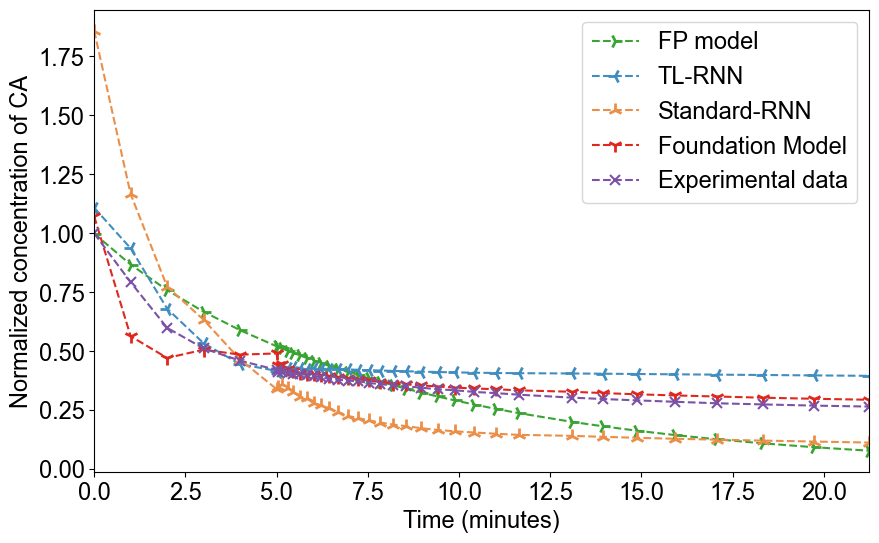

MSE for FP:  0.34108222013369915
MSE for standard:  1.5538180209545884
MSE for transfer learning:  0.21739969906928555
MSE for foundation model:  0.0900438606030141


In [48]:
#prediction performance of CA
j = -1
i = 0
Y_iT = np.array(RNN_predictT[j,:,i]).reshape(-1)
Y_i = np.array(RNN_predict[j,:,i]).reshape(-1)
Y_iF = np.array(RNN_predictF[j,:,i]).reshape(-1)
Y_real_i = np.array(Y_real[j,:,i]).reshape(-1)

plt.figure(figsize=(10,6))
plt.rc('font', size=17)
plt.plot(X1, CA_list, '--', color='#39A432', marker='4', linewidth=1.5, markersize=10, markeredgewidth=2)
plt.plot(X1, Y_iT, '--', color='#428DBF', marker='3', linewidth=1.5, markersize=10, markeredgewidth=2)
plt.plot(X1, Y_i, '--', color='#EB8E47', marker='2', linewidth=1.5, markersize=10, markeredgewidth=2)
plt.plot(X1, Y_iF, '--', color='#E0271E', marker='1', linewidth=1.5, markersize=10, markeredgewidth=2)
plt.plot(X1, Y_real_i, '--', color='#7A52A6', marker='x', linewidth=1.5, markersize=7.5, markeredgewidth=1.5)
plt.legend(['FP model','TL-RNN','Standard-RNN','Foundation Model','Experimental data'])
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized concentration of CA")
plt.margins(x=0)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('7shots_9th_conditions_CA_trial2.pdf')
plt.show()

a = 0
b = 0
c = 0
d = 0
for i in range(len(Y_iT)):
    a += (CA_list[i] - Y_real_i[i])**2 #FP
    b += (Y_iT[i] - Y_real_i[i])**2 #TL
    c += (Y_i[i] - Y_real_i[i])**2 #standard
    d += (Y_iF[i] - Y_real_i[i])**2 #FM

print('MSE for FP: ', np.mean(a))
print('MSE for standard: ', np.mean(c))
print('MSE for transfer learning: ', np.mean(b))
print('MSE for foundation model: ', np.mean(d))

meta NOT subset; don't know how to subset; dropped


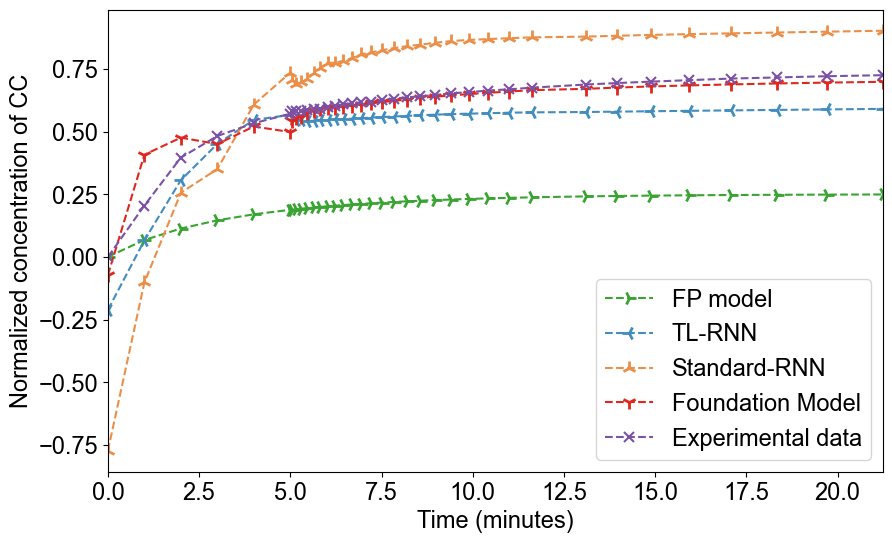

MSE for FP:  5.869165167217474
MSE for standard:  1.7464745067138077
MSE for transfer learning:  0.2936273052863089
MSE for foundation model:  0.06701940324918602


In [49]:
#prediction performance of CC
j = -1
i = 1
Y_iT = np.array(RNN_predictT[j,:,i]).reshape(-1)
Y_i = np.array(RNN_predict[j,:,i]).reshape(-1)
Y_iF = np.array(RNN_predictF[j,:,i]).reshape(-1)
Y_real_i = np.array(Y_real[j,:,i]).reshape(-1)

plt.figure(figsize=(10,6))
plt.rc('font', size=17)
plt.plot(X1, CC_list, '--', color='#39A432', marker='4', linewidth=1.5, markersize=10, markeredgewidth=2)
plt.plot(X1, Y_iT, '--', color='#428DBF', marker='3', linewidth=1.5, markersize=10, markeredgewidth=2)
plt.plot(X1, Y_i, '--', color='#EB8E47', marker='2', linewidth=1.5, markersize=10, markeredgewidth=2)
plt.plot(X1, Y_iF, '--', color='#E0271E', marker='1', linewidth=1.5, markersize=10, markeredgewidth=2)
plt.plot(X1, Y_real_i, '--', color='#7A52A6', marker='x', linewidth=1.5, markersize=7.5, markeredgewidth=1.5)
plt.legend(['FP model','TL-RNN','Standard-RNN','Foundation Model','Experimental data'])
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized concentration of CC")
plt.margins(x=0)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('7shots_9th_conditions_CC_trial2.pdf')
plt.show()

a = 0
b = 0
c = 0
d = 0
for i in range(len(Y_iT)):
    a += (CC_list[i] - Y_real_i[i])**2 #FP
    b += (Y_iT[i] - Y_real_i[i])**2 #TL
    c += (Y_i[i] - Y_real_i[i])**2 #standard
    d += (Y_iF[i] - Y_real_i[i])**2 #FM

print('MSE for FP: ', np.mean(a))
print('MSE for standard: ', np.mean(c))
print('MSE for transfer learning: ', np.mean(b))
print('MSE for foundation model: ', np.mean(d))

# Comparision over condition 8 test

In [50]:
name = "Sheet" + str(8)
print(name)
raw_input = pd.read_excel('Updated_photochemical_Experiment.xlsx',name)
X=raw_input.values.astype(np.float64)
X1 = [round(X1[i], 2) for i in range(len(X1))]
Y1 = X[:,10]
Y2 = X[:,11]
Y3 = X[:,9]

print(X1)
CA_list,CC_list,CE_list = CSimulation(0.4,qp_240)

Sheet8
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 5.04, 5.15, 5.3, 5.46, 5.64, 5.82, 6.02, 6.23, 6.45, 6.69, 6.95, 7.22, 7.52, 7.84, 8.19, 8.56, 8.97, 9.41, 9.89, 10.42, 11.0, 11.63, 13.1, 13.95, 14.89, 15.92, 17.07, 18.33, 19.72, 21.24]


meta NOT subset; don't know how to subset; dropped


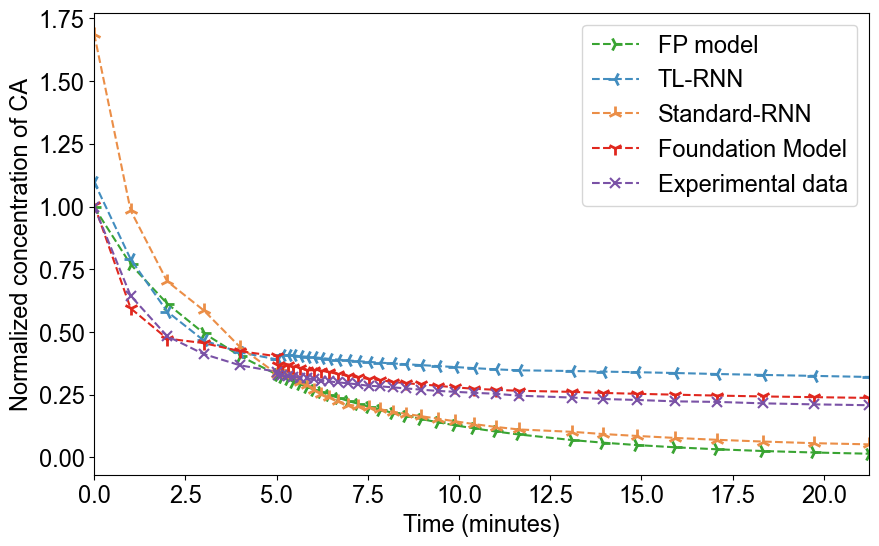

MSE for FP:  0.48738974994679246
MSE for standard:  1.0030345702066001
MSE for transfer learning:  0.3311620742326878
MSE for foundation model:  0.037099453856650054


In [51]:
j = -2
i = 0
Y_iT = np.array(RNN_predictT[j,:,i]).reshape(-1)
Y_i = np.array(RNN_predict[j,:,i]).reshape(-1)
Y_iF = np.array(RNN_predictF[j,:,i]).reshape(-1)
Y_real_i = np.array(Y_real[j,:,i]).reshape(-1)

plt.figure(figsize=(10,6))
plt.rc('font', size=17)
plt.plot(X1, CA_list, '--', color='#39A432', marker='4', linewidth=1.5, markersize=10, markeredgewidth=2)
plt.plot(X1, Y_iT, '--', color='#428DBF', marker='3', linewidth=1.5, markersize=10, markeredgewidth=2)
plt.plot(X1, Y_i, '--', color='#EB8E47', marker='2', linewidth=1.5, markersize=10, markeredgewidth=2)
plt.plot(X1, Y_iF, '--', color='#E0271E', marker='1', linewidth=1.5, markersize=10, markeredgewidth=2)
plt.plot(X1, Y_real_i, '--', color='#7A52A6', marker='x', linewidth=1.5, markersize=7.5, markeredgewidth=1.5)
plt.legend(['FP model','TL-RNN','Standard-RNN','Foundation Model','Experimental data'])
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized concentration of CA")
plt.margins(x=0)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('7shots_8th_conditions_CA_trial2.pdf')
plt.show()

a = 0
b = 0
c = 0
d = 0
for i in range(len(Y_iT)):
    a += (CA_list[i] - Y_real_i[i])**2 #FP
    b += (Y_iT[i] - Y_real_i[i])**2 #TL
    c += (Y_i[i] - Y_real_i[i])**2 #standard
    d += (Y_iF[i] - Y_real_i[i])**2 #FM

print('MSE for FP: ', np.mean(a))
print('MSE for standard: ', np.mean(c))
print('MSE for transfer learning: ', np.mean(b))
print('MSE for foundation model: ', np.mean(d))

meta NOT subset; don't know how to subset; dropped


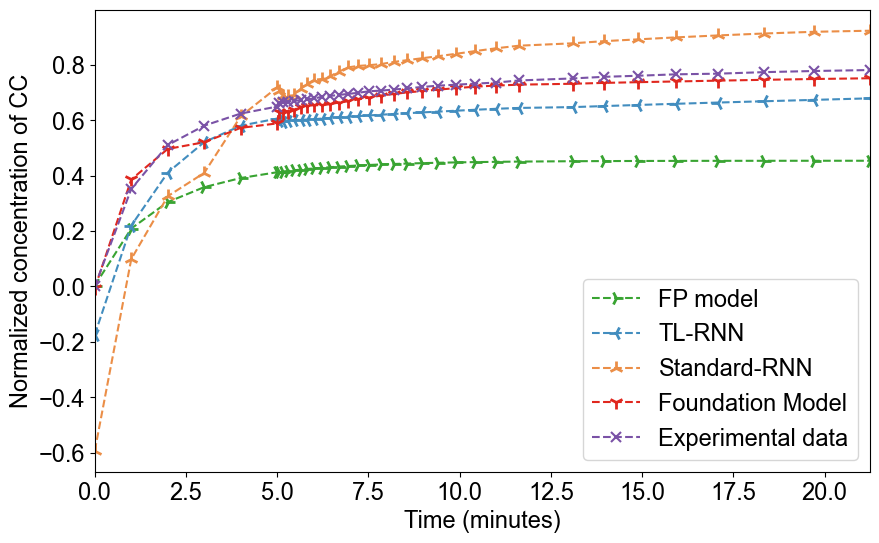

MSE for FP:  2.5530961018358713
MSE for standard:  0.7954044614115863
MSE for transfer learning:  0.3054829391924363
MSE for foundation model:  0.029303611092185027


In [52]:
j = -2
i = 1
Y_iT = np.array(RNN_predictT[j,:,i]).reshape(-1)
Y_i = np.array(RNN_predict[j,:,i]).reshape(-1)
Y_iF = np.array(RNN_predictF[j,:,i]).reshape(-1)
Y_real_i = np.array(Y_real[j,:,i]).reshape(-1)

plt.figure(figsize=(10,6))
plt.rc('font', size=17)
plt.plot(X1, CC_list, '--', color='#39A432', marker='4', linewidth=1.5, markersize=10, markeredgewidth=2)
plt.plot(X1, Y_iT, '--', color='#428DBF', marker='3', linewidth=1.5, markersize=10, markeredgewidth=2)
plt.plot(X1, Y_i, '--', color='#EB8E47', marker='2', linewidth=1.5, markersize=10, markeredgewidth=2)
plt.plot(X1, Y_iF, '--', color='#E0271E', marker='1', linewidth=1.5, markersize=10, markeredgewidth=2)
plt.plot(X1, Y_real_i, '--', color='#7A52A6', marker='x', linewidth=1.5, markersize=7.5, markeredgewidth=1.5)
plt.legend(['FP model','TL-RNN','Standard-RNN','Foundation Model','Experimental data'])
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized concentration of CC")
plt.margins(x=0)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.savefig('7shots_8th_conditions_CC_trial2.pdf')
plt.show()

a = 0
b = 0
c = 0
d = 0
for i in range(len(Y_iT)):
    a += (CC_list[i] - Y_real_i[i])**2 #FP
    b += (Y_iT[i] - Y_real_i[i])**2 #TL
    c += (Y_i[i] - Y_real_i[i])**2 #standard
    d += (Y_iF[i] - Y_real_i[i])**2 #FM
    
print('MSE for FP: ', np.mean(a))
print('MSE for standard: ', np.mean(c))
print('MSE for transfer learning: ', np.mean(b))
print('MSE for foundation model: ', np.mean(d))